In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Overview
In recent years, Twitter has emerged as a prominent platform for marketing and targeted advertising. It is also a valuable conduit for the collection of consumer data, and natural language processing (NLP) methods can provide a solution for companies seeking to track consumer sentiment with respect to their brands and products. This project developed and implemented several NLP models to classify tweets as negative or positive. 

Data cleaning and augmentation, EDA, modeling, and evaluation were performed, and a random forest classifier was chosen as the the final model for the project. Because we wanted to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed since it is sensitive to both types of error. An F1 score is a mix of both precision and recall (F1=1 means perfect recall and precision), so interpretation of the results is more easily described in terms of recall and precision. 

An F1 accuracy score of 0.89 (recall=.85, precision=.94) was attained at the end of the project's modeling process. The recall score of .85 meant that 85% of negative tweets were correctly classified as negative, while the precision score of .94 indicated that 94% of tweets classified as negative were truly negative. 

An alternate logistic regression model with an F1 accuracy score of 0.89 (recall=.83, precision=.97) is also available for use by interested parties.

## Business Understanding:
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information, so a model that captures both sentiments as accurately as possible is most desirable.  

## Data Understanding:
The baseline data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfer with model performance, and additional negative sentiment data was used to augment the baseline data. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). This data augmentation greatly improved model performance.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as vz
from src import functions as fn
from src import classes as cl 

import pandas as pd
import numpy as np
from numpy.random import default_rng

from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Modeling I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/processed',\
                           'baseline_data.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

emotion                                              stems  \
0        1  3g iphon 3 hr tweet rise austin dead need upgr...   
1        0  know awesom ipad iphon app like appreci design...   
2        0                                wait ipad also sale   
3        1             hope year festiv crashi year iphon app   
4        0  great stuff fri marissa mayer googl tim reilli...   

                                              lemmas  \
0  3g iphone hr tweeting rise austin dead need up...   
1  know awesome ipad iphone app likely appreciate...   
2                                wait ipad also sale   
3          hope year festival crashy year iphone app   
4  great stuff fri marissa mayer google tim reill...   

                                               tweet       brand_product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

                    hashtags  
0  ['#RISE_Austin', '#SXSW']  
1                  ['#SXSW']  
2         ['#iPad', '#SXSW']  
3                  ['#sxsw']  
4                  ['#SXSW']

## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        8908 non-null   int64 
 1   stems          8908 non-null   object
 2   lemmas         8908 non-null   object
 3   tweet          8908 non-null   object
 4   brand_product  3271 non-null   object
 5   hashtags       8899 non-null   object
dtypes: int64(1), object(5)
memory usage: 417.7+ KB


## EDA & Corpus Statistics 

In [6]:
df.emotion.value_counts(normalize=True)

2    0.602941
0    0.333184
1    0.063875
Name: emotion, dtype: float64

## Splitting Emotions

In [7]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]
neutral = df[df['emotion']==2]

## Emotion Vocabularies

#### Positive Lemma Vocabulary

In [8]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4516

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [9]:
pos_words = fn.words(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0441    
apple     		0.0333    
google    		0.0262    
store     		0.02      
iphone    		0.0197    
app       		0.0142    
new       		0.0129    
austin    		0.0105    
pop       		0.0076    
android   		0.0074    
get       		0.0065    
launch    		0.0062    
party     		0.0054    
one       		0.0054    
line      		0.0052    
great     		0.0049    
time      		0.0049    
via       		0.0047    
day       		0.0045    
free      		0.0044    
social    		0.0044    
circle    		0.0044    
win       		0.0044    
cool      		0.0043    
map       		0.0042    


<font size="4">Fill</font> 

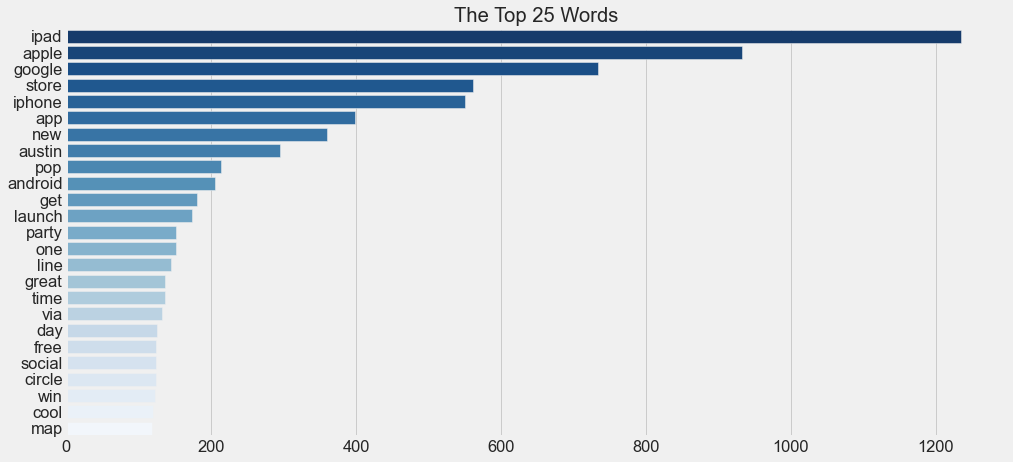

In [10]:
vz.top_word_list(pos_words, 25)

<font size="4">Fill</font>

#### Negative Lemmas Vocabulary

In [11]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

1883

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [12]:
neg_words = fn.words(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

ipad      		0.0373    
iphone    		0.0294    
google    		0.0271    
apple     		0.022     
app       		0.0108    
store     		0.0084    
new       		0.0077    
like      		0.0077    
circle    		0.0066    
need      		0.0063    
social    		0.0056    
apps      		0.0054    
design    		0.0052    
people    		0.0052    
austin    		0.005     
get       		0.0045    
android   		0.0043    
one       		0.0041    
think     		0.0041    
time      		0.0041    
line      		0.0039    
launch    		0.0039    
day       		0.0039    
today     		0.0038    
look      		0.0038    


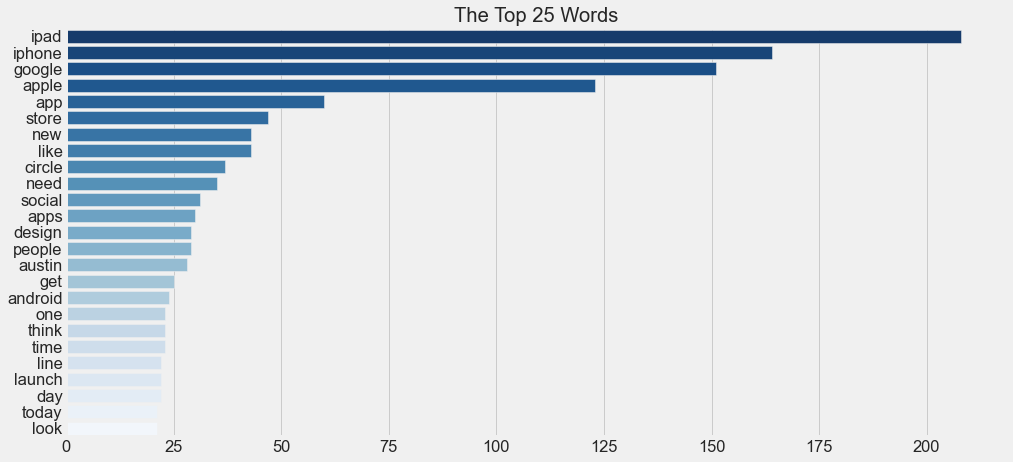

In [13]:
vz.top_word_list(neg_words, 25)

<font size="4">FILL.</font> 

#### Neutral Lemmas Vocabulary

In [14]:
vocab_lem_neu = fn.vocabulary(neutral.lemmas)
len(vocab_lem_pos)

4516

In [15]:
neu_words = fn.words(neutral.lemmas)
fn.word_frequencies(neu_words, 25)

Word 			Frequency

google    		0.0353    
ipad      		0.0309    
apple     		0.0257    
store     		0.0185    
iphone    		0.0174    
new       		0.0139    
austin    		0.0131    
circle    		0.0104    
social    		0.0102    
launch    		0.0099    
today     		0.0089    
app       		0.0074    
android   		0.0074    
pop       		0.0074    
network   		0.0073    
via       		0.0058    
line      		0.0056    
called    		0.0056    
free      		0.0054    
get       		0.0051    
party     		0.0049    
mobile    		0.0049    
major     		0.0046    
possibly  		0.0038    
check     		0.0036    


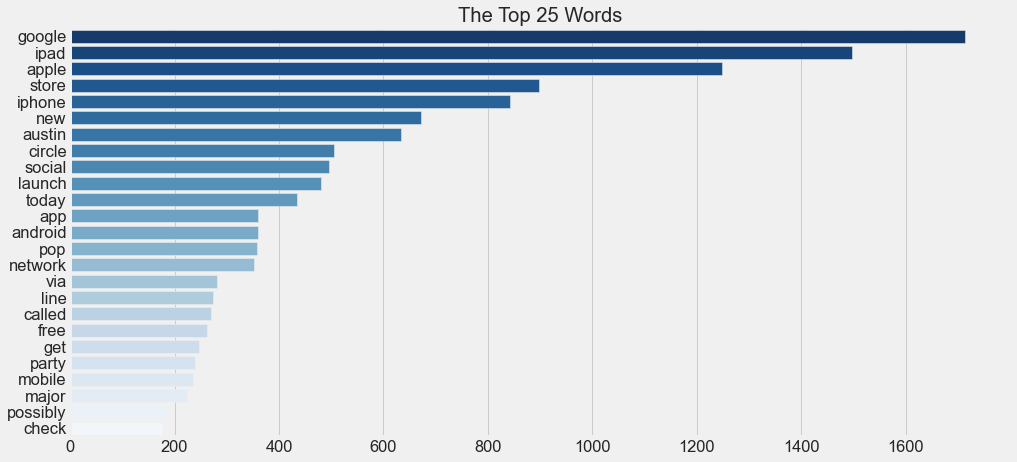

In [16]:
vz.top_word_list(neu_words, 25)

## Word Clouds

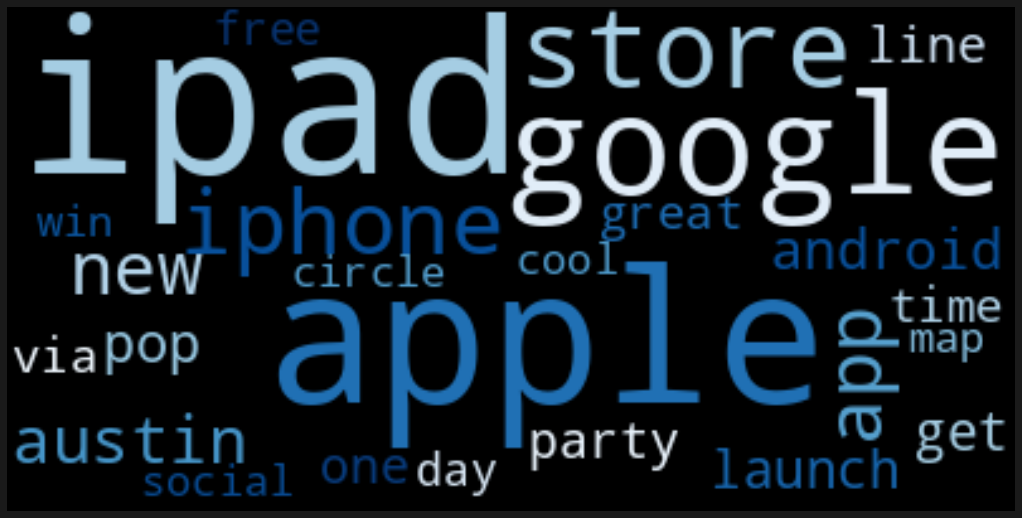

In [17]:
vz.word_cloud(pos_words, 25)

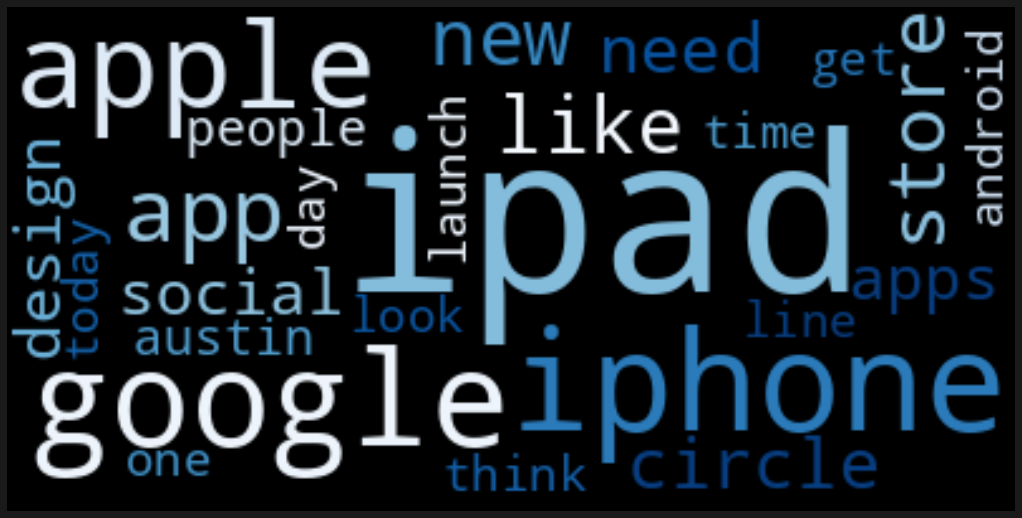

In [18]:
vz.word_cloud(neg_words, 25)

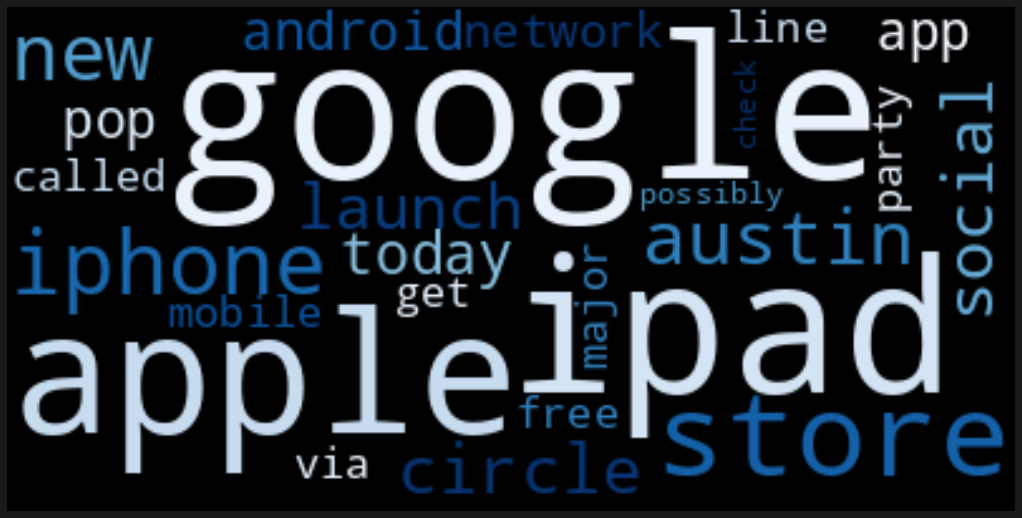

In [19]:
vz.word_cloud(neu_words, 25)

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [20]:
# filtering
binary_data = df[(df['emotion'] == 0) |\
                 (df['emotion'] == 1)].copy()

In [21]:
# resetting the index
binary_data.reset_index(drop=True, inplace=True)

## Checking The First Five Rows

In [22]:
# checking the first five rows
binary_data.head()

emotion                                              stems  \
0        1  3g iphon 3 hr tweet rise austin dead need upgr...   
1        0  know awesom ipad iphon app like appreci design...   
2        0                                wait ipad also sale   
3        1             hope year festiv crashi year iphon app   
4        0  great stuff fri marissa mayer googl tim reilli...   

                                              lemmas  \
0  3g iphone hr tweeting rise austin dead need up...   
1  know awesome ipad iphone app likely appreciate...   
2                                wait ipad also sale   
3          hope year festival crashy year iphone app   
4  great stuff fri marissa mayer google tim reill...   

                                               tweet       brand_product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

                    hashtags  
0  ['#RISE_Austin', '#SXSW']  
1                  ['#SXSW']  
2         ['#iPad', '#SXSW']  
3                  ['#sxsw']  
4                  ['#SXSW']

In [23]:
# checking the info
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [24]:
# checking for nulls
binary_data.isna().sum()

emotion            0
stems              0
lemmas             0
tweet              0
brand_product    357
hashtags           6
dtype: int64

## Checking Value Counts & Class Balance

In [25]:
# checking the value counts
binary_data['emotion'].value_counts()

0    2968
1     569
Name: emotion, dtype: int64

In [26]:
binary_data['emotion'].value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

<font size="4">The classes are very imbalanced, and this will most likely have to be dealt with during the modeling process.</font>

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [27]:
data_lemms = binary_data.lemmas
data_stems = binary_data.stems
target = binary_data['emotion']

In [28]:
# checking lengths
idx = [data_lemms, data_stems, target]
for i in idx:
    print(f'{len(i)}')

3537
3537
3537


In [29]:
# Creating data & target
X_lem = data_lemms
y_lem = target

In [30]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

3537
3537


In [31]:
zips = zip(X_lem, y_lem)
report_base_df = pd.DataFrame(zips, columns=['X_lem', 'y_lem'])

In [32]:
# path = os.path.join(gparent, 'data/processed', 'report_baseline.csv')
# report_base_df.to_csv(path, index=False)

## Creating Modeling & Holdout Data

<font size="4">We are going to focus on modeling with the lemmatized data, but we'll prepare a train-validation-test split for the stemmed data as well.</font>

<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [33]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem,
                                                                           y_lem)

In [34]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

2652
2652
885
885


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [35]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training,
                                                             y_lem_training)

In [36]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

1989
1989
663
663


#### Stemmed Data

In [37]:
X_stem = data_stems
y_stem = target

In [38]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

3537
3537


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [39]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem,
                                                                               y_stem)

In [40]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

2652
2652
885
885


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [41]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training,
                                                                 y_stem_training)

In [42]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

1989
1989
663
663


## Modeling Objects
<font size="4">Instantiating various objects needed in the modeling process.</font>

In [43]:
# creating f1 scorer
f1 = fn.f1

# creating Harness
modeling = cl.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer()

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Creating a Basline Classifier
<font size="4">A dummy classifier will serve as the baseline model for the project.</font>

In [44]:
Base = DummyClassifier(strategy='most_frequent')

## Creating Pipeline & Fitting Model

In [45]:
steps = [('tfidf', tfidf), ('clf', Base)]
baseline = Pipeline(steps=steps)

baseline.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', DummyClassifier(strategy='most_frequent'))])

## 5-Fold Cross-Validation: Average F1=0

In [46]:
modeling.report(baseline, X_lem_train, y_lem_train, 'Dummy CLF',
                'tfidf/no ngrams, no sampling')

Dummy CLF has an average F1 of 0.0


array([0., 0., 0., 0., 0.])

In [47]:
modeling.history

Name  Accuracy (F1)                         Notes
0  Dummy CLF            0.0  tfidf/no ngrams, no sampling

## Confusion Matrices

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


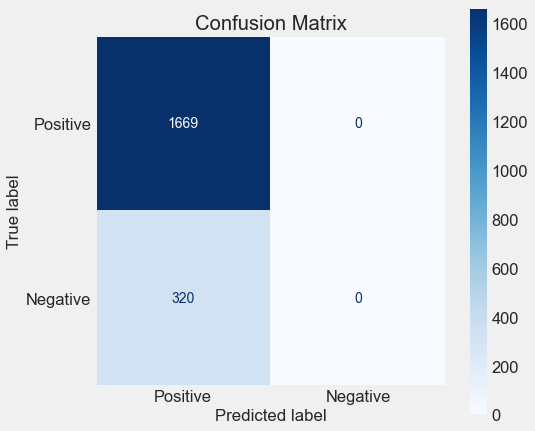

F1  Recall  Precision
0  0.0     0.0        0.0

In [48]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


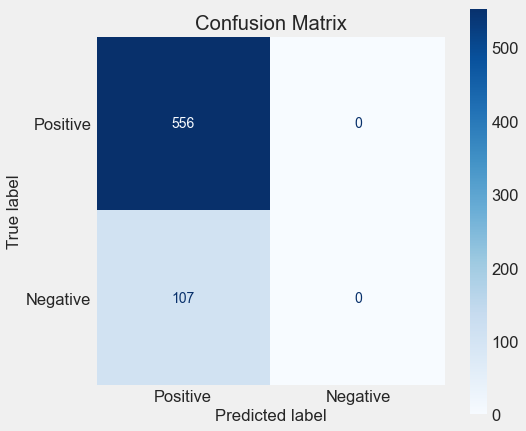

F1  Recall  Precision
0  0.0     0.0        0.0

In [49]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Baseline Model Metrics:
<font size="4">F1=0, Recall=0, Precision=0</font>

## Pickling Baseline Model

In [50]:
# path = os.path.join(gparent, 'models', 'baseline_model.pkl')
# file = open(path, 'wb')
# pickle.dump(baseline, file)
# file.close()

## First Simple Model
<font size="4">A logistic regression classifier will serve as the baseline model for the project.</font>

In [51]:
LR = LogisticRegression(max_iter=1000, random_state = 2021, n_jobs=-1, verbose=2)

## Creating Pipeline & Fitting Model

In [52]:
steps = [('tfidf', tfidf), ('clf', LR)]
simple = Pipeline(steps=steps)

simple.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## 5-Fold Cross-Validation: Average F1=0.071395

In [53]:
modeling.report(simple, X_lem_train, y_lem_train, 'LR simple',
                'tfidf/no ngrams, no sampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


LR simple has an average F1 of 0.07139461065712163


array([0.03076923, 0.08955224, 0.11764706, 0.03076923, 0.08823529])

In [54]:
modeling.history

Name  Accuracy (F1)                         Notes
0  Dummy CLF       0.000000  tfidf/no ngrams, no sampling
1  LR simple       0.071395  tfidf/no ngrams, no sampling

## Confusion Matrices

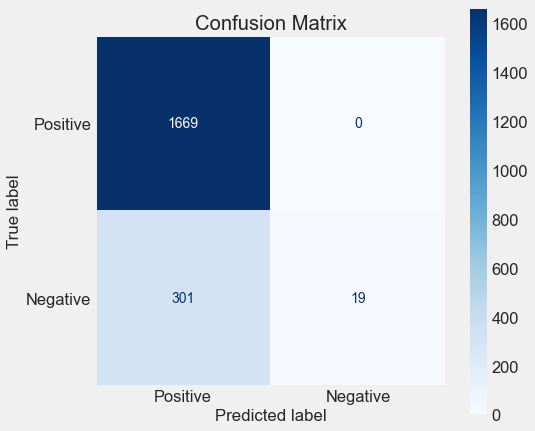

F1    Recall  Precision
0  0.112094  0.059375        1.0

In [55]:
fn.confusion_report(simple, X_lem_train, y_lem_train)

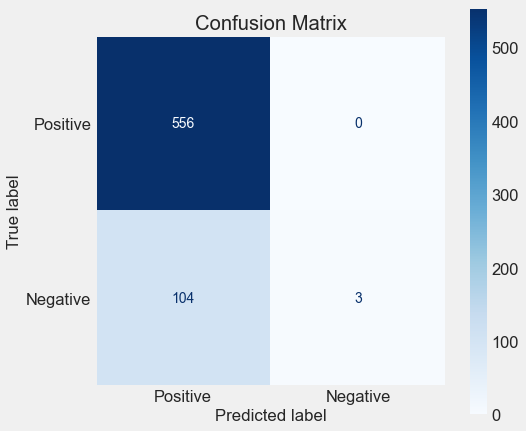

F1    Recall  Precision
0  0.054545  0.028037        1.0

In [56]:
fn.confusion_report(simple, X_lem_val, y_lem_val)

## Metrics:
<font size="4">F1=0.054545, Recall=0.028037, Precision=1.0</font>

## Coefficients & Odds

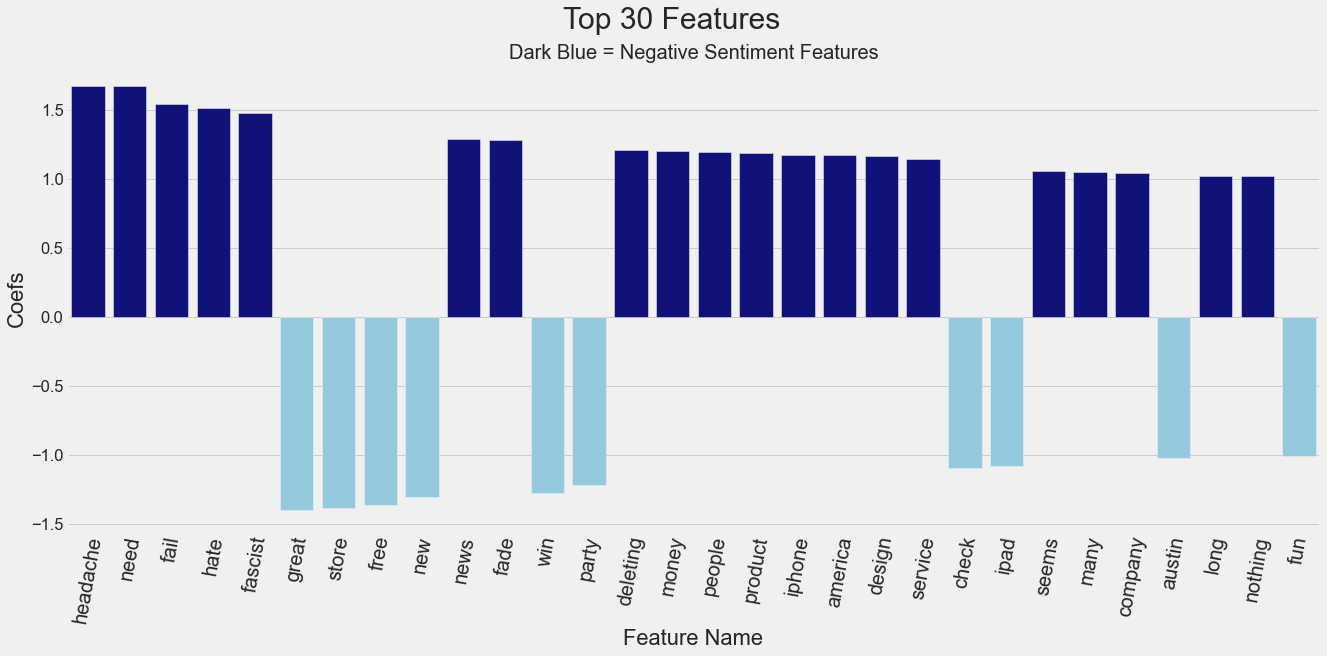

In [57]:
vz.base_coefs(simple)

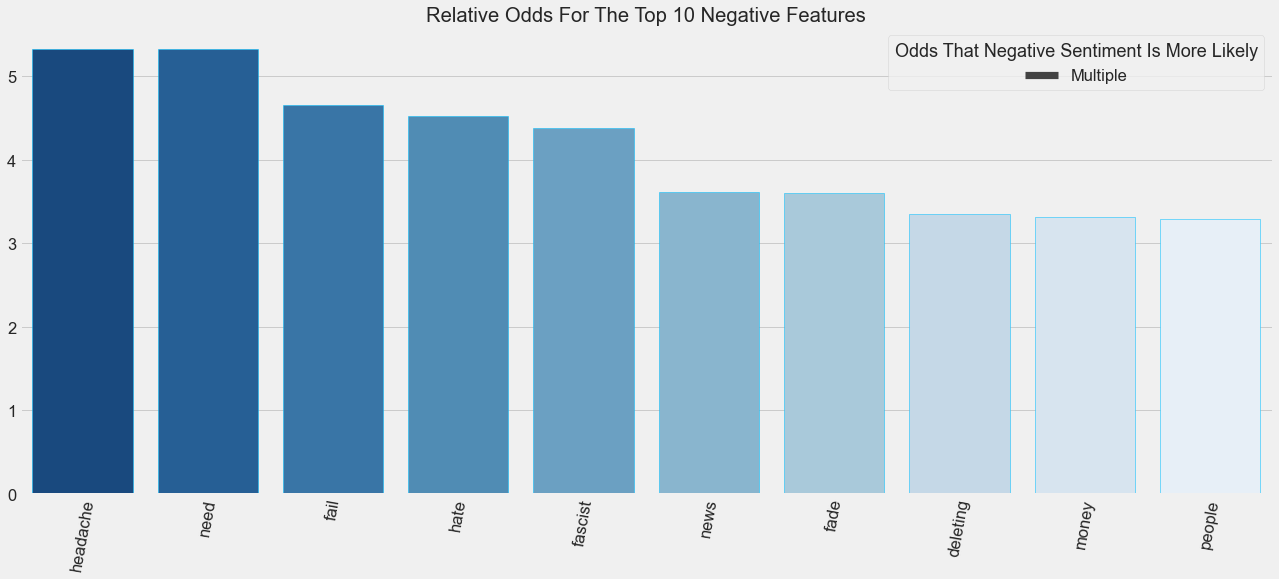

In [58]:
vz.base_neg_odds(simple)

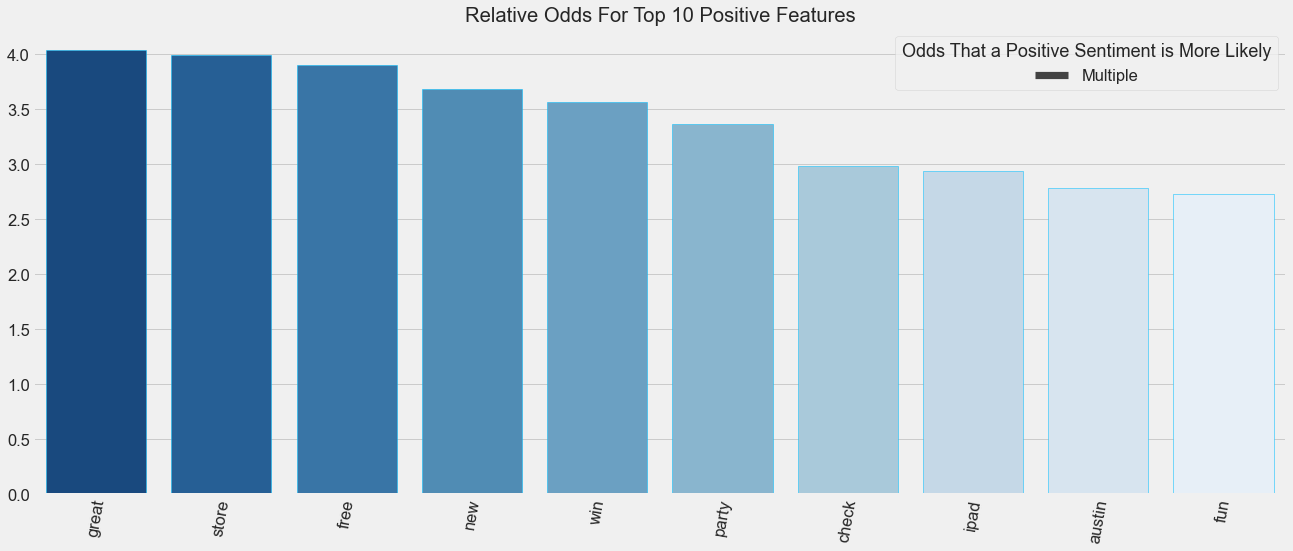

In [59]:
vz.base_pos_odds(simple)

## Fitting Simple Model on All Lemmatized Baseline Data

In [60]:
simple.fit(X_lem, y_lem)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Pickling Simple Model

In [61]:
# path = os.path.join(gparent, 'models', 'simple_model.pkl')
# file = open(path, 'wb')
# pickle.dump(simple, file)
# file.close()

## Simple Minority Oversampling

In [62]:
target.value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

In [63]:
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', LR)]
simple_mo = Pipeline(steps=steps)

In [64]:
simple_mo.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [65]:
modeling.report(simple_mo, X_lem_train, y_lem_train, 'simple_mo',
                'minority oversampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


simple_mo has an average F1 of 0.48333863118994547


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.47457627, 0.528     , 0.46511628, 0.45669291, 0.49230769])

In [66]:
modeling.history

Name  Accuracy (F1)                         Notes
0  Dummy CLF       0.000000  tfidf/no ngrams, no sampling
1  LR simple       0.071395  tfidf/no ngrams, no sampling
2  simple_mo       0.483339         minority oversampling

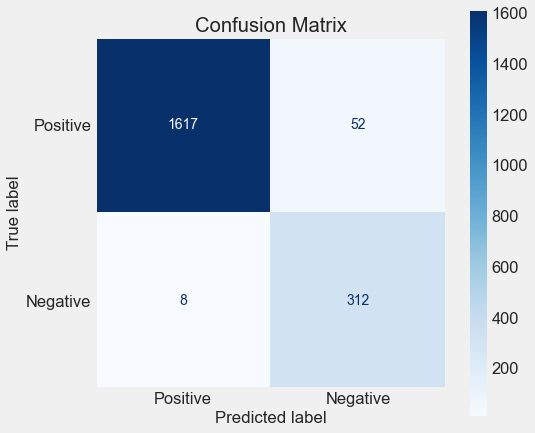

F1  Recall  Precision
0  0.912281   0.975   0.857143

In [67]:
fn.confusion_report(simple_mo, X_lem_train, y_lem_train)

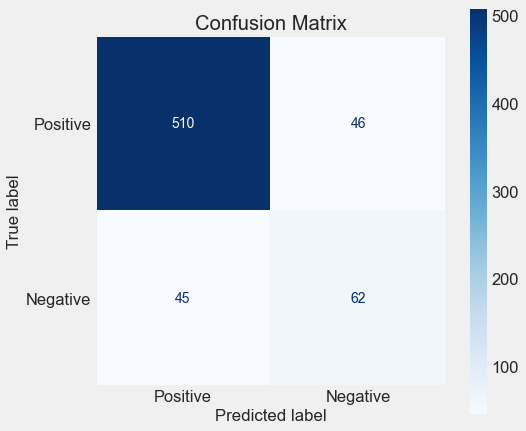

F1    Recall  Precision
0  0.576744  0.579439   0.574074

In [68]:
fn.confusion_report(simple_mo, X_lem_val, y_lem_val)

## Simple Minority Oversampling GridSearch

In [69]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [70]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [71]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [72]:
# grid_clf_f1 = GridSearchCV(simple_mo, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [73]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [74]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  LogisticRegression(C=1.2742749857031321, max_iter=1000,
                     n_jobs=-1, random_state=2021, solver='liblinear', verbose=2))]

In [75]:
tuned_simple_mo = Pipeline(steps=saved_steps)
tuned_simple_mo.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(C=1.2742749857031321, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [76]:
modeling.report(tuned_simple_mo, X_lem_train, y_lem_train, 'tuned_simple_mo',
                f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_simple_mo has an average F1 of 0.4787646911825066


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.45217391, 0.55      , 0.43902439, 0.46031746, 0.49230769])

In [77]:
modeling.history

Name  Accuracy (F1)  \
0        Dummy CLF       0.000000   
1        LR simple       0.071395   
3  tuned_simple_mo       0.478765   
2        simple_mo       0.483339   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
3  [('tfidf', TfidfVectorizer()), ('oversample', ...  
2                              minority oversampling

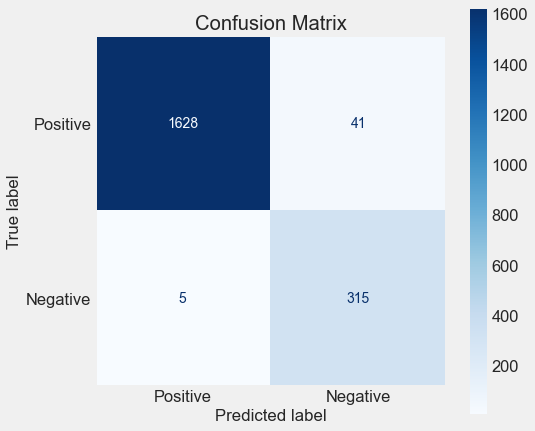

F1    Recall  Precision
0  0.931953  0.984375   0.884831

In [78]:
fn.confusion_report(tuned_simple_mo, X_lem_train, y_lem_train)

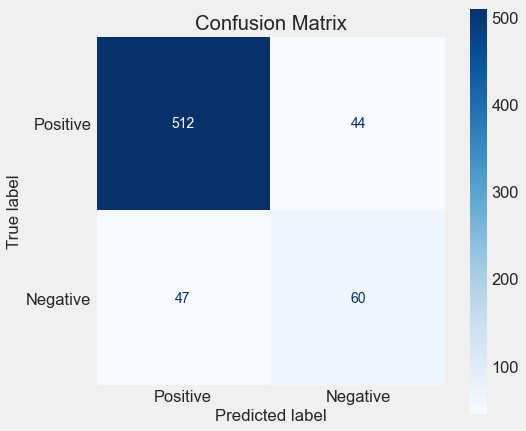

F1    Recall  Precision
0  0.56872  0.560748   0.576923

In [79]:
fn.confusion_report(tuned_simple_mo, X_lem_val, y_lem_val)

## Simple SMOTE 

In [80]:
steps = [('tfidf', tfidf), ('oversample', sm), ('clf', LR)]
simple_smote = Pipeline(steps=steps)

In [81]:
simple_smote.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [82]:
modeling.report(simple_smote, X_lem_train, y_lem_train, 'simple smote',
                'smote')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


simple smote has an average F1 of 0.4500063830905937


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


array([0.44642857, 0.528     , 0.41538462, 0.40909091, 0.45112782])

In [83]:
modeling.history

Name  Accuracy (F1)  \
0        Dummy CLF       0.000000   
1        LR simple       0.071395   
4     simple smote       0.450006   
2  tuned_simple_mo       0.478765   
3        simple_mo       0.483339   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
4                                              smote  
2  [('tfidf', TfidfVectorizer()), ('oversample', ...  
3                              minority oversampling

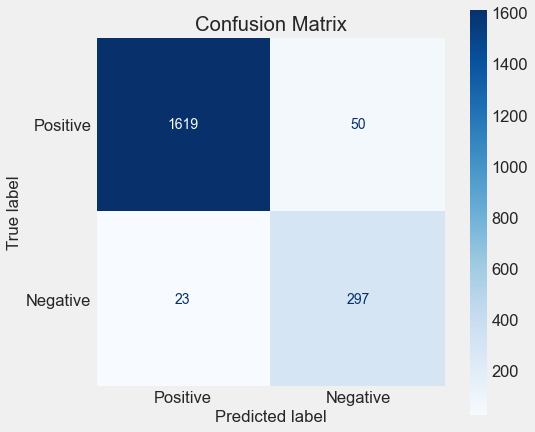

F1    Recall  Precision
0  0.890555  0.928125   0.855908

In [84]:
fn.confusion_report(simple_smote, X_lem_train, y_lem_train)

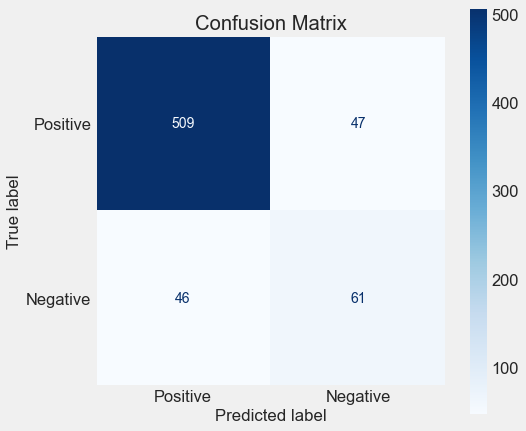

F1    Recall  Precision
0  0.567442  0.570093   0.564815

In [85]:
fn.confusion_report(simple_smote, X_lem_val, y_lem_val)

## Simple SMOTE GridSearch

In [86]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }


In [87]:
# grid_clf = GridSearchCV(simple_smote, param_grid = parameters,
#                         n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [88]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [89]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample', SMOTE(random_state=2021)),
 ('clf',
  LogisticRegression(C=5.455594781168514, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [90]:
tuned_simple_smote = Pipeline(steps=saved_steps)
tuned_simple_smote.fit( X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(C=5.455594781168514, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [91]:
modeling.report(tuned_simple_smote, X_lem_train, y_lem_train,
                'tuned_simple_smote', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear]tuned_simple_smote has an average F1 of 0.4611620114772445


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.44036697, 0.5       , 0.43103448, 0.46774194, 0.46666667])

In [92]:
modeling.history

Name  Accuracy (F1)  \
0           Dummy CLF       0.000000   
1           LR simple       0.071395   
2        simple smote       0.450006   
5  tuned_simple_smote       0.461162   
3     tuned_simple_mo       0.478765   
4           simple_mo       0.483339   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
2                                              smote  
5  [('tfidf', TfidfVectorizer()), ('oversample', ...  
3  [('tfidf', TfidfVectorizer()), ('oversample', ...  
4                              minority oversampling

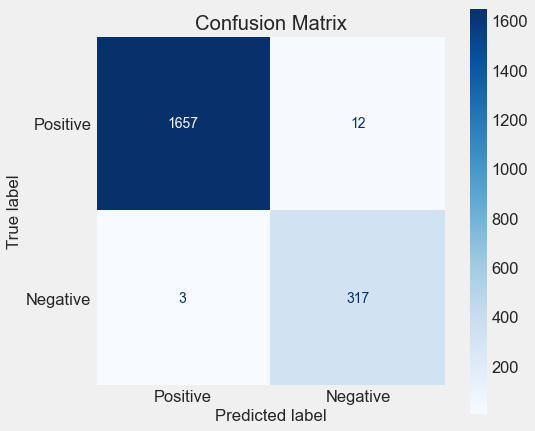

F1    Recall  Precision
0  0.976888  0.990625   0.963526

In [93]:
fn.confusion_report(tuned_simple_smote, X_lem_train, y_lem_train)

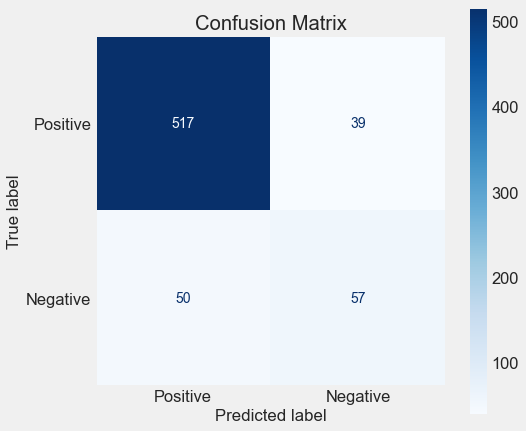

F1   Recall  Precision
0  0.561576  0.53271    0.59375

In [94]:
fn.confusion_report(tuned_simple_smote, X_lem_val, y_lem_val)

## Naive Bayes

In [95]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB())])

In [96]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes', 'minority oversamp')

multibayes has an average F1 of 0.4854208738826665


array([0.47222222, 0.47482014, 0.47058824, 0.50314465, 0.50632911])

In [97]:
modeling.history

Name  Accuracy (F1)  \
0           Dummy CLF       0.000000   
1           LR simple       0.071395   
2        simple smote       0.450006   
3  tuned_simple_smote       0.461162   
4     tuned_simple_mo       0.478765   
5           simple_mo       0.483339   
6          multibayes       0.485421   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
2                                              smote  
3  [('tfidf', TfidfVectorizer()), ('oversample', ...  
4  [('tfidf', TfidfVectorizer()), ('oversample', ...  
5                              minority oversampling  
6                                  minority oversamp

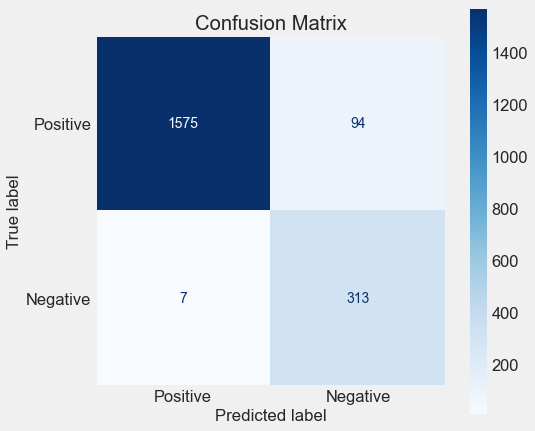

F1    Recall  Precision
0  0.861073  0.978125   0.769042

In [98]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

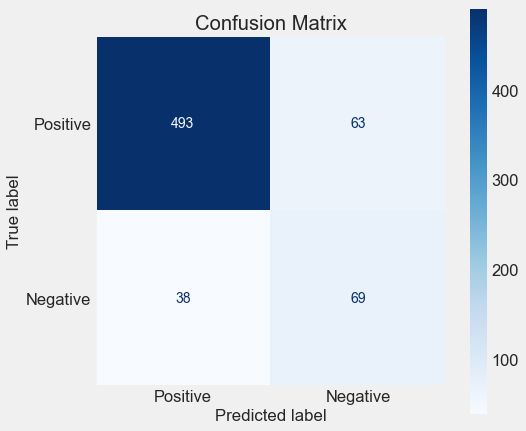

F1   Recall  Precision
0  0.577406  0.64486   0.522727

In [99]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Naive Bayes

In [100]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [101]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, 25, .5, .75, 1],
    'clf__class_prior': [None, [.16, .84]],
    'clf__fit_prior': [True, False]
    }


In [102]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [103]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [104]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf', MultinomialNB(alpha=0.5))]

In [105]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB(alpha=0.5))])

In [106]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_multibayes',
                f'{steps}')

tuned_multibayes has an average F1 of 0.4840121240172661


array([0.50359712, 0.45669291, 0.45945946, 0.47682119, 0.52348993])

In [107]:
modeling.history

Name  Accuracy (F1)  \
0           Dummy CLF       0.000000   
1           LR simple       0.071395   
2        simple smote       0.450006   
3  tuned_simple_smote       0.461162   
4     tuned_simple_mo       0.478765   
5           simple_mo       0.483339   
7    tuned_multibayes       0.484012   
6          multibayes       0.485421   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
2                                              smote  
3  [('tfidf', TfidfVectorizer()), ('oversample', ...  
4  [('tfidf', TfidfVectorizer()), ('oversample', ...  
5                              minority oversampling  
7  [('tfidf', TfidfVectorizer()), ('oversample', ...  
6                                  minority oversamp

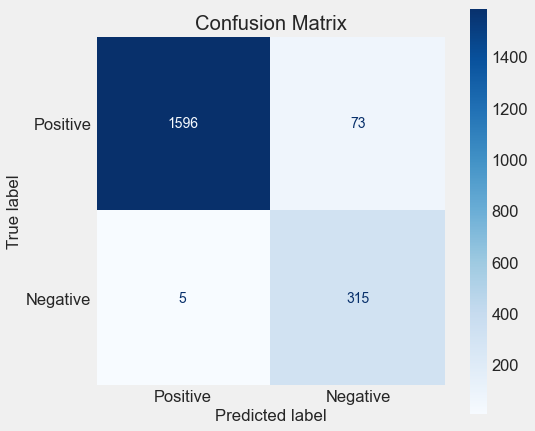

F1    Recall  Precision
0  0.889831  0.984375   0.811856

In [108]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

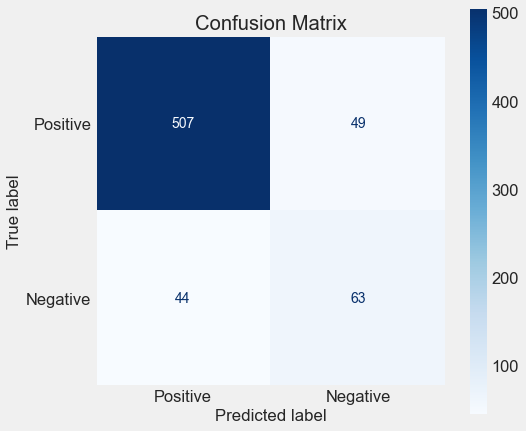

F1    Recall  Precision
0  0.575342  0.588785     0.5625

In [109]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest

In [110]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', RF)]
rf_pipe = Pipeline(steps=steps)
rf_pipe.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [111]:
modeling.report(rf_pipe, X_lem_train, y_lem_train, 'rf_mo',
                'default random forest')

rf_mo has an average F1 of 0.3945792415948822


array([0.38095238, 0.36781609, 0.44210526, 0.4       , 0.38202247])

In [112]:
modeling.history

Name  Accuracy (F1)  \
0           Dummy CLF       0.000000   
1           LR simple       0.071395   
8               rf_mo       0.394579   
2        simple smote       0.450006   
3  tuned_simple_smote       0.461162   
4     tuned_simple_mo       0.478765   
5           simple_mo       0.483339   
6    tuned_multibayes       0.484012   
7          multibayes       0.485421   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
8                              default random forest  
2                                              smote  
3  [('tfidf', TfidfVectorizer()), ('oversample', ...  
4  [('tfidf', TfidfVectorizer()), ('oversample', ...  
5                              minority oversampling  
6  [('tfidf', TfidfVectorizer()), ('oversample', ...  
7                                  minority oversamp

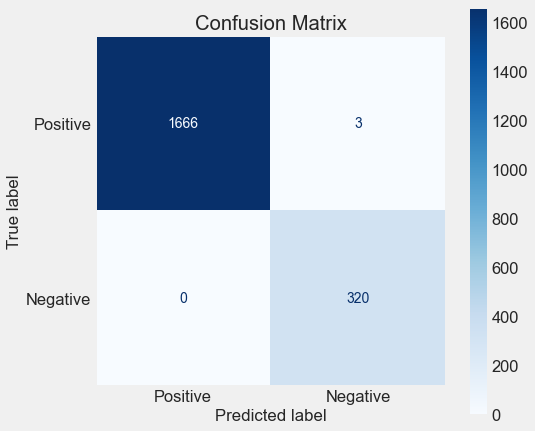

F1  Recall  Precision
0  0.995334     1.0   0.990712

In [113]:
fn.confusion_report(rf_pipe, X_lem_train, y_lem_train)

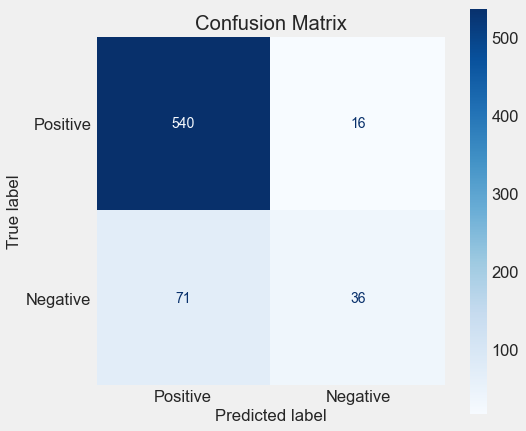

F1    Recall  Precision
0  0.45283  0.336449   0.692308

In [114]:
fn.confusion_report(rf_pipe, X_lem_val, y_lem_val)

## Tuned Random Forest

In [115]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [116]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [117]:
# grid_clf = GridSearchCV(rf_pipe, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [118]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [119]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  RandomForestClassifier(max_features=None, min_samples_split=10, n_estimators=50,
                         n_jobs=-1, random_state=2021))]

In [120]:
tuned_rf = Pipeline(steps=saved_steps)
tuned_rf.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 RandomForestClassifier(max_features=None, min_samples_split=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=2021))])

In [121]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf', f'{steps}')

tuned_rf has an average F1 of 0.46890918980355834


array([0.5203252 , 0.42975207, 0.47887324, 0.41935484, 0.4962406 ])

In [122]:
modeling.history

Name  Accuracy (F1)  \
0           Dummy CLF       0.000000   
1           LR simple       0.071395   
2               rf_mo       0.394579   
3        simple smote       0.450006   
4  tuned_simple_smote       0.461162   
9            tuned_rf       0.468909   
5     tuned_simple_mo       0.478765   
6           simple_mo       0.483339   
7    tuned_multibayes       0.484012   
8          multibayes       0.485421   

                                               Notes  
0                       tfidf/no ngrams, no sampling  
1                       tfidf/no ngrams, no sampling  
2                              default random forest  
3                                              smote  
4  [('tfidf', TfidfVectorizer()), ('oversample', ...  
9  [('tfidf', TfidfVectorizer()), ('oversample', ...  
5  [('tfidf', TfidfVectorizer()), ('oversample', ...  
6                              minority oversampling  
7  [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                                  minority oversamp

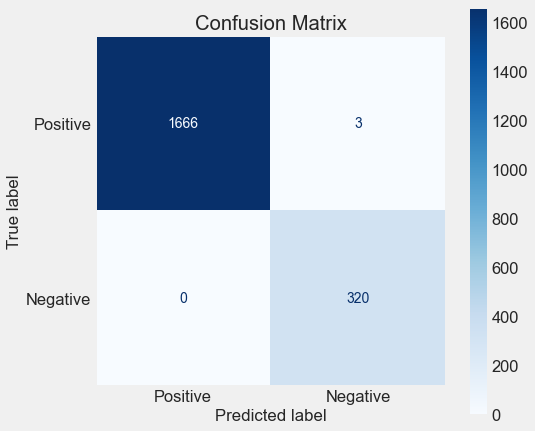

F1  Recall  Precision
0  0.995334     1.0   0.990712

In [123]:
fn.confusion_report(tuned_rf, X_lem_train, y_lem_train)

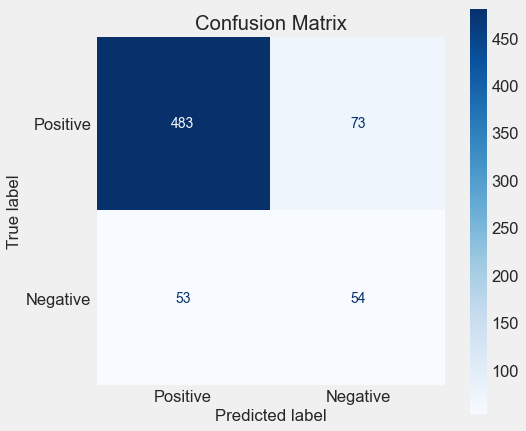

F1    Recall  Precision
0  0.461538  0.504673   0.425197

In [124]:
fn.confusion_report(tuned_rf, X_lem_val, y_lem_val)

## Importing Augmented Data

In [125]:
path = os.path.join(gparent, 'data/processed', 'augmented_data.csv')
aug = pd.read_csv(path, encoding='unicode_escape')

## EDA & Augmented Corpus Statistics 

In [126]:
aug.emotion.value_counts(normalize=True)

2    0.477762
0    0.264010
1    0.258228
Name: emotion, dtype: float64

## Splitting Emotions

In [127]:
positive = aug[aug['emotion']==0]
negative = aug[aug['emotion']==1]
neutral = aug[aug['emotion']==2]

## Augmented Emotion Vocabularies

#### Positive Lemma Vocabulary

In [128]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4631

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [129]:
pos_words = fn.cloud_cleaner_lem(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0441    
apple     		0.0333    
google    		0.0262    
store     		0.02      
iphone    		0.0197    
app       		0.0143    
new       		0.0129    
austin    		0.0105    
pop       		0.0076    
android   		0.0074    
get       		0.0065    
launch    		0.0062    
party     		0.0054    
one       		0.0054    
line      		0.0052    
great     		0.0049    
time      		0.0049    
via       		0.0047    
day       		0.0045    
free      		0.0044    
social    		0.0044    
circle    		0.0044    
win       		0.0044    
cool      		0.0043    
map       		0.0043    


<font size="4">Fill</font> 

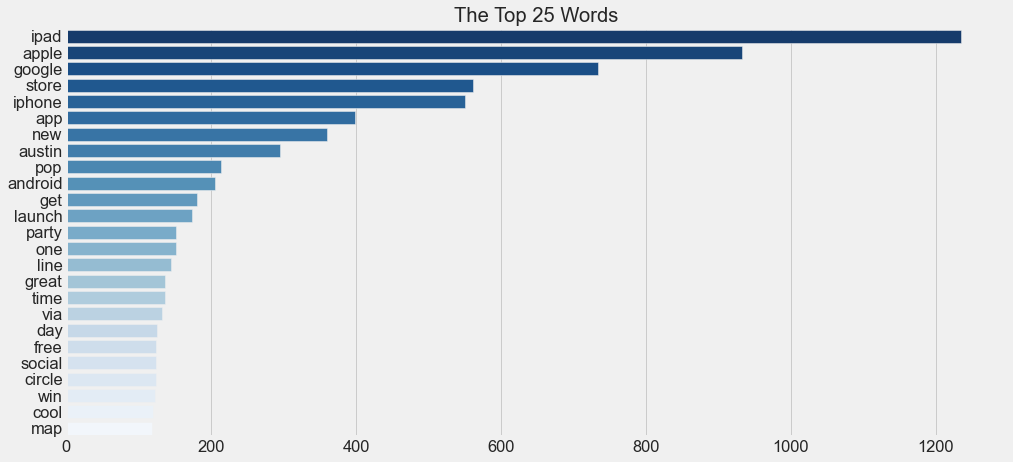

In [130]:
vz.top_word_list(pos_words, 25)

<font size="4">4 out of the top 5 words relate to the brands, and Apple dominates with 3 out of those top 5.</font>

#### Negative Lemmas Vocabulary

In [131]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

4947

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [132]:
neg_words = fn.cloud_cleaner_lem(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

unhappy   		0.0369    
iphone    		0.0145    
apple     		0.0141    
ipad      		0.011     
need      		0.0083    
google    		0.0074    
one       		0.0074    
phone     		0.0073    
get       		0.0069    
like      		0.0067    
aapl      		0.0062    
battery   		0.0058    
want      		0.0055    
u         		0.0055    
f0ck      		0.0054    
people    		0.0051    
make      		0.0048    
new       		0.0046    
computer  		0.0046    
time      		0.0044    
sh1t      		0.0044    
store     		0.0043    
please    		0.0041    
app       		0.004     
future    		0.0037    


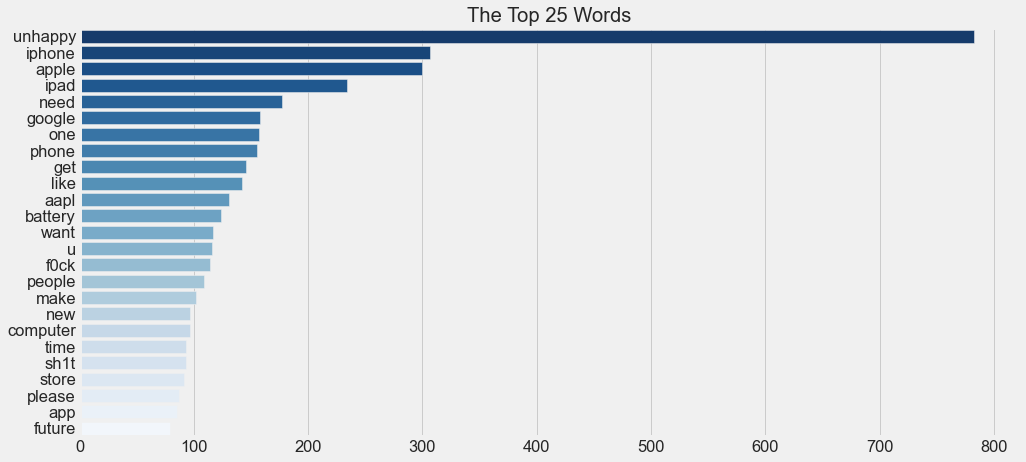

In [133]:
vz.top_word_list(neg_words, 25)

<font size="4">Unhappy dominates the negative token list with greater than double the frequency of the next most frequent word.</font> 

#### Neutral Lemmas Vocabulary

In [134]:
vocab_lem_neu = fn.vocabulary(neutral.lemmas)
len(vocab_lem_pos)

4631

In [135]:
neu_words = fn.cloud_cleaner_lem(neutral.lemmas)
fn.word_frequencies(neu_words, 25)

Word 			Frequency

google    		0.0354    
ipad      		0.0309    
apple     		0.0258    
store     		0.0185    
iphone    		0.0174    
new       		0.0139    
austin    		0.0131    
circle    		0.0104    
social    		0.0102    
launch    		0.0099    
today     		0.009     
app       		0.0074    
android   		0.0074    
pop       		0.0074    
network   		0.0073    
via       		0.0058    
line      		0.0057    
called    		0.0056    
free      		0.0054    
get       		0.0051    
party     		0.0049    
mobile    		0.0049    
major     		0.0046    
possibly  		0.0038    
u         		0.0037    


## Word Clouds

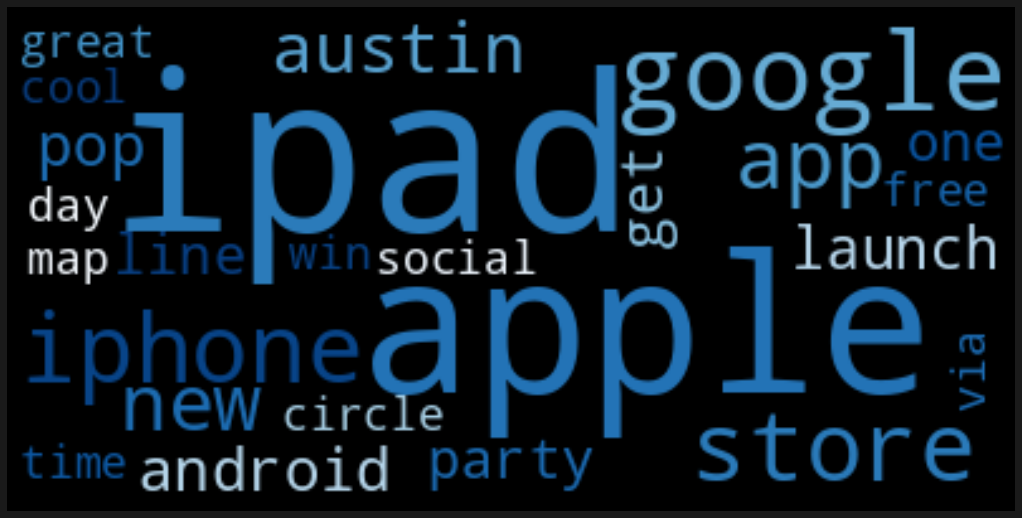

In [136]:
vz.word_cloud(pos_words, 25)

<font size="4">`ipad`, and `apple` are the most used words in `Positive` tweets.</font>

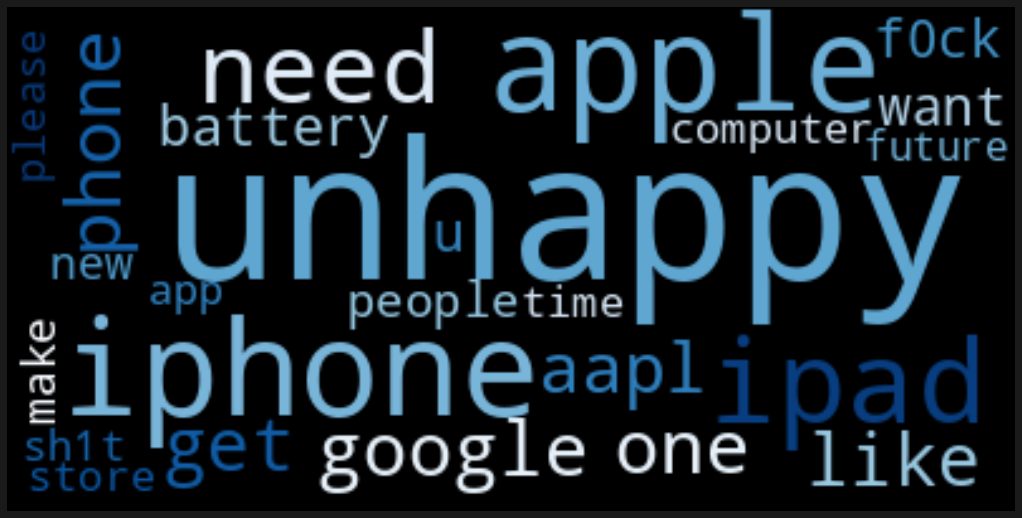

In [137]:
vz.word_cloud(neg_words, 25)

<font size="4">`unhappy`, `apple`, and `iphone` are the most used words in `Negative` tweets.</font>

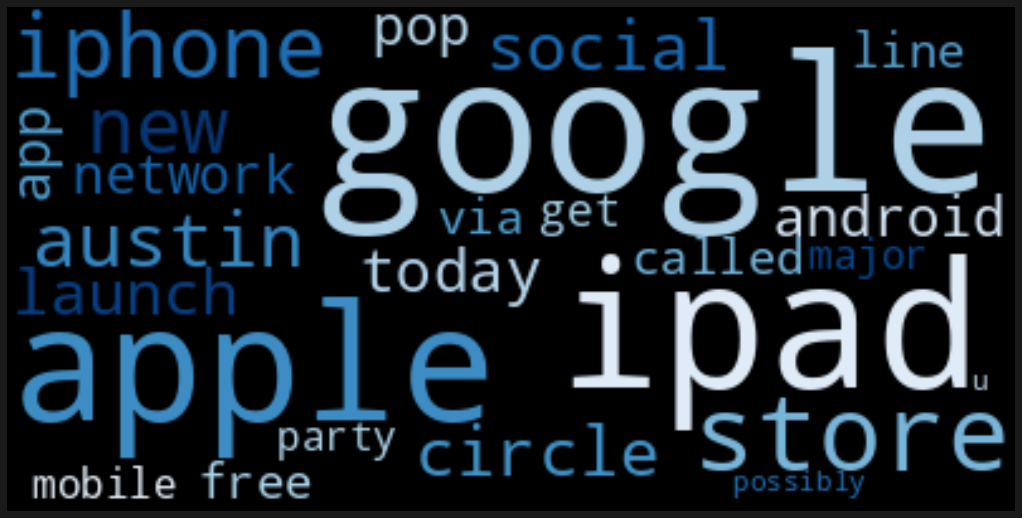

In [138]:
vz.word_cloud(neu_words, 25)

<font size="4">`google`, `apple`, and `ipad` are the most used words in `Neutral` tweets.</font>

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [139]:
# filtering
binary_augmented = aug[(aug['emotion'] == 0) |\
                 (aug['emotion'] == 1)].copy()

In [140]:
# resetting the index
binary_augmented.reset_index(drop=True, inplace=True)

In [141]:
# checking the first five rows
binary_augmented.head()

emotion                                              stems  \
0        1  3g iphon 3 hr tweet rise austin dead need upgr...   
1        0  know awesom ipad iphon app like appreci design...   
2        0                                wait ipad also sale   
3        1             hope year festiv crashi year iphon app   
4        0  great stuff fri marissa mayer googl tim reilli...   

                                              lemmas  \
0  3g iphone 3 hr tweeting rise austin dead need ...   
1  know awesome ipad iphone app likely appreciate...   
2                                wait ipad also sale   
3          hope year festival crashy year iphone app   
4  great stuff fri marissa mayer google tim reill...   

                                               tweet       brand_product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

                    hashtags  
0  ['#RISE_Austin', '#SXSW']  
1                  ['#SXSW']  
2         ['#iPad', '#SXSW']  
3                  ['#sxsw']  
4                  ['#SXSW']

In [142]:
# checking the info
binary_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        5871 non-null   int64 
 1   stems          5871 non-null   object
 2   lemmas         5871 non-null   object
 3   tweet          5871 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3868 non-null   object
dtypes: int64(1), object(5)
memory usage: 275.3+ KB


In [143]:
# checking for nulls
binary_augmented.isna().sum()

emotion             0
stems               0
lemmas              0
tweet               0
brand_product    2691
hashtags         2003
dtype: int64

In [144]:
# checking the value counts
binary_augmented['emotion'].value_counts()

0    2968
1    2903
Name: emotion, dtype: int64

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [145]:
aug_lemms = binary_augmented.lemmas
aug_stems = binary_augmented.stems
aug_target = binary_augmented['emotion']

In [146]:
# checking lengths
idx = [aug_lemms, aug_stems, aug_target]
for i in idx:
    print(f'{len(i)}')

5871
5871
5871


In [147]:
# Creating data & target
X_lem_aug = aug_lemms
y_lem_aug = aug_target

In [148]:
zips = zip(X_lem_aug, y_lem_aug)
report_aug_df = pd.DataFrame(zips, columns=['X_lem_aug', 'y_lem_aug'])

In [149]:
# path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
# report_aug_df.to_csv(path, index=False)

In [150]:
# checking lengths
print(len(X_lem_aug))
print(len(y_lem_aug))

5871
5871


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [151]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem_aug,
                                                                           y_lem_aug)

In [152]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [153]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training,
                                                             y_lem_training)

In [154]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

3302
3302
1101
1101


#### Stemmed Data

In [155]:
X_stem_aug = aug_stems
y_stem_aug = aug_target

In [156]:
# checking lengths
print(len(X_stem_aug))
print(len(y_stem_aug))

5871
5871


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [157]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem_aug,
                                                                               y_stem_aug)

In [158]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [159]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training,
                                                                 y_stem_training)

In [160]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

3302
3302
1101
1101


In [161]:
len(X_stem) == len(y_stem)

True

## Tuned Simple Model on Augmented Data

In [162]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [163]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [164]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [165]:
# grid_clf_f1 = GridSearchCV(simple, param_grid = parameters,
#                             n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [166]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [167]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
 ('clf',
  LogisticRegression(C=11.288378916846883, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [168]:
tuned_simple = Pipeline(steps=saved_steps)
tuned_simple.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [169]:
modeling.report(tuned_simple, X_lem_train, y_lem_train, 'tuned_simple_aug',
                f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_simple_aug has an average F1 of 0.896377949045436


array([0.89108911, 0.90113452, 0.89768977, 0.89621087, 0.89576547])

In [170]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1            LR simple       0.071395   
2                rf_mo       0.394579   
3         simple smote       0.450006   
4   tuned_simple_smote       0.461162   
5             tuned_rf       0.468909   
6      tuned_simple_mo       0.478765   
7            simple_mo       0.483339   
8     tuned_multibayes       0.484012   
9           multibayes       0.485421   
10    tuned_simple_aug       0.896378   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                        tfidf/no ngrams, no sampling  
2                               default random forest  
3                                               smote  
4   [('tfidf', TfidfVectorizer()), ('oversample', ...  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7                               minority oversampling  
8   [('tfidf', TfidfVectorizer()), ('oversample', ...  
9                                   minority oversamp  
10  [('tfidf', TfidfVectorizer()), ('oversample', ...

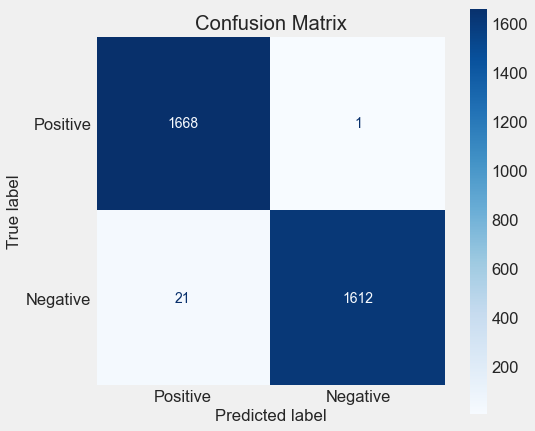

F1   Recall  Precision
0  0.993222  0.98714    0.99938

In [171]:
fn.confusion_report(tuned_simple, X_lem_train, y_lem_train)

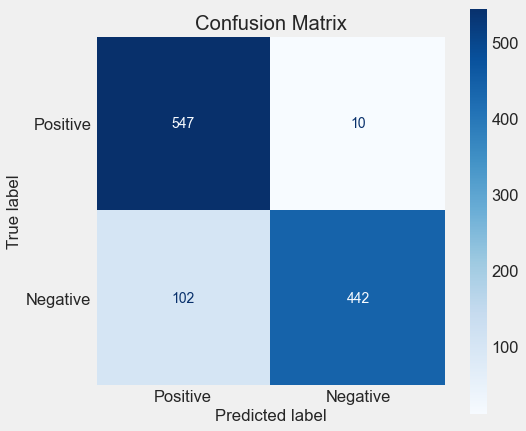

F1  Recall  Precision
0  0.88755  0.8125   0.977876

In [172]:
fn.confusion_report(tuned_simple, X_lem_val, y_lem_val)

## Coefficients & Odds

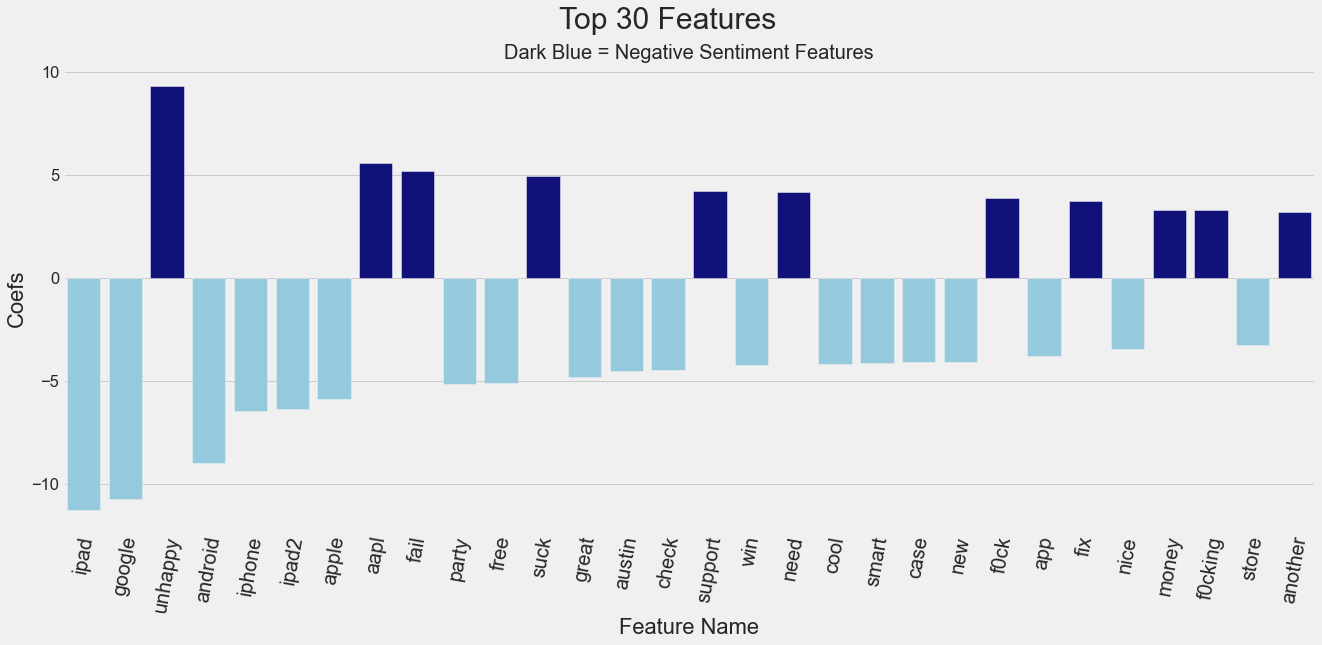

In [173]:
vz.base_coefs(tuned_simple)

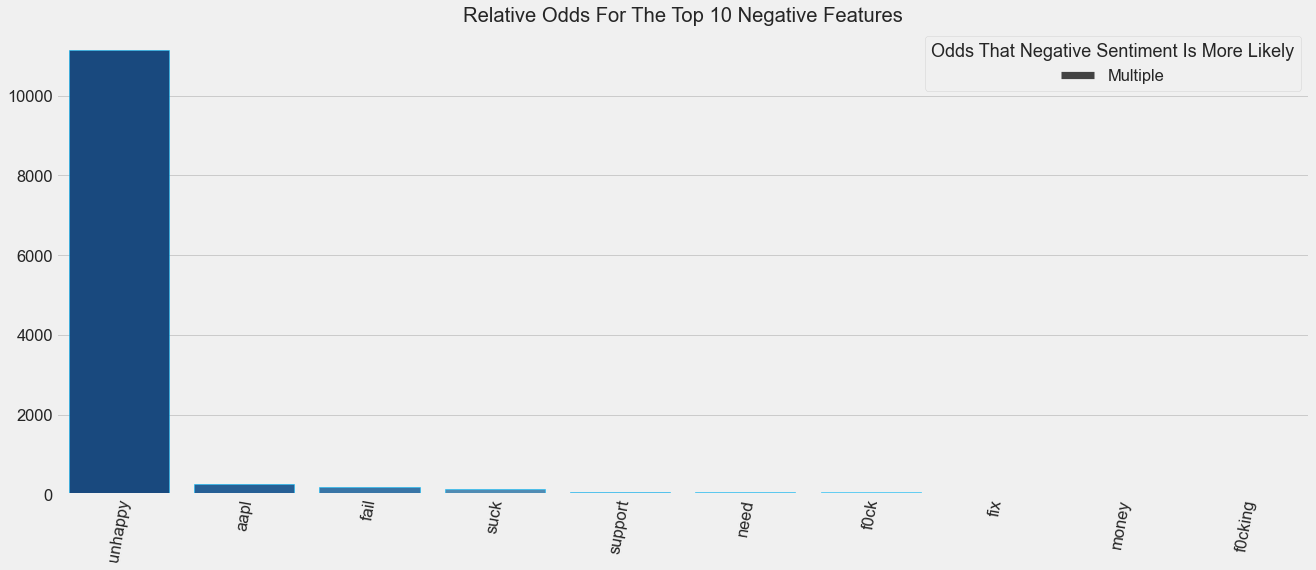

In [174]:
vz.base_neg_odds(tuned_simple)

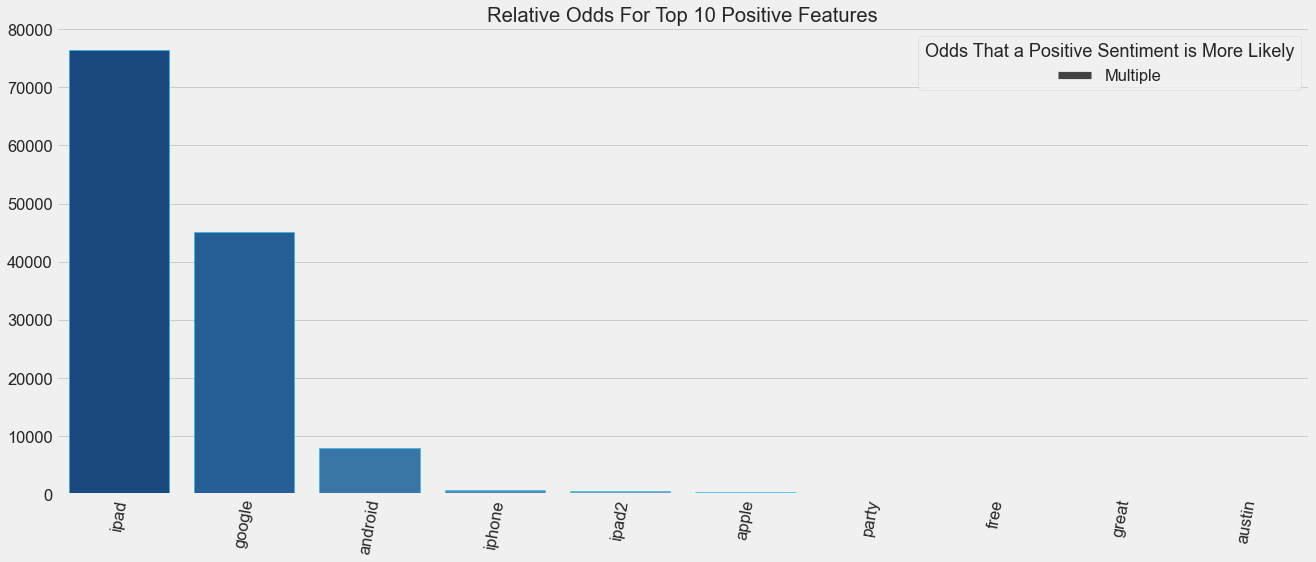

In [175]:
vz.base_pos_odds(tuned_simple)

## Fitting Simple Model on All Lemmatized, Augmented Data

In [176]:
tuned_simple.fit(X_lem, y_lem)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

## Pickling Augmented Simple Model

In [178]:
# path = os.path.join(gparent, 'models', 'simple_model_aug.pkl')
# file = open(path, 'wb')
# pickle.dump(tuned_simple, file)
# file.close()

## Augmented Naive Bayes

In [185]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [186]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes_aug',
                'augmented_data')

multibayes_aug has an average F1 of 0.8589519418868138


array([0.85245902, 0.87086093, 0.86333333, 0.86634461, 0.84176183])

In [187]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
12      multibayes_aug       0.858952   
11    tuned_simple_aug       0.896378   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
12                                     augmented_data  
11  [('tfidf', TfidfVectorizer()), ('oversample', ...

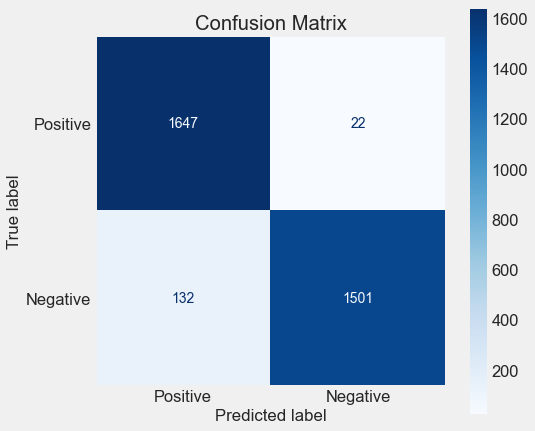

F1    Recall  Precision
0  0.951204  0.919167   0.985555

In [188]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

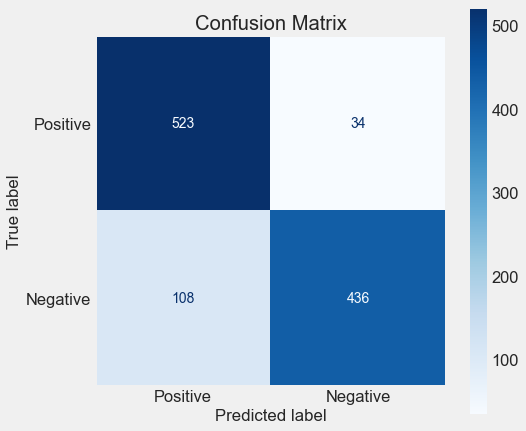

F1    Recall  Precision
0  0.859961  0.801471    0.92766

In [189]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Augmented Naive Bayes

In [190]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [191]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, .25, .5, .75, 1],
    'clf__fit_prior': [True, False]
    }


In [192]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [193]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [194]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
 ('clf', MultinomialNB(alpha=0.25, fit_prior=False))]

In [195]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
                ('clf', MultinomialNB(alpha=0.25, fit_prior=False))])

In [196]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_mnb_aug',
                f'{steps}')

tuned_mnb_aug has an average F1 of 0.8735455234135003


array([0.86468647, 0.8830313 , 0.88146912, 0.87725041, 0.86129032])

In [197]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
11      multibayes_aug       0.858952   
13       tuned_mnb_aug       0.873546   
12    tuned_simple_aug       0.896378   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
11                                     augmented_data  
13  [('tfidf', TfidfVectorizer()), ('clf', Multino...  
12  [('tfidf', TfidfVectorizer()), ('oversample', ...

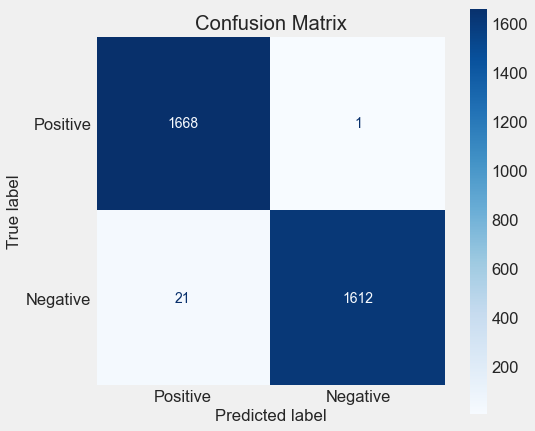

F1   Recall  Precision
0  0.993222  0.98714    0.99938

In [198]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

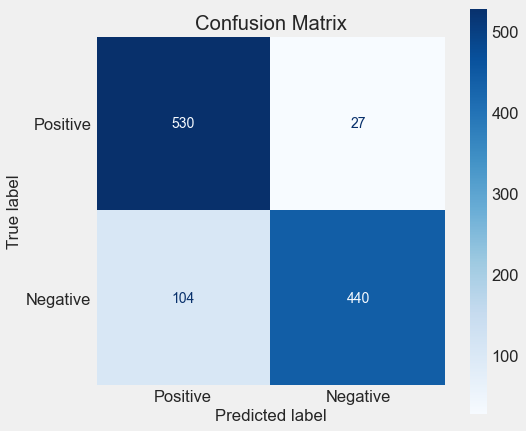

F1    Recall  Precision
0  0.870425  0.808824   0.942184

In [199]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest on Augmented Data

In [200]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('clf', RF)]
rf_aug = Pipeline(steps=steps)
rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [201]:
modeling.report(rf_aug, X_lem_train, y_lem_train, 'rf_aug', 'augmented data')

rf_aug has an average F1 of 0.8966883615884242


array([0.89326765, 0.90131579, 0.89250814, 0.90196078, 0.89438944])

In [202]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
11      multibayes_aug       0.858952   
12       tuned_mnb_aug       0.873546   
13    tuned_simple_aug       0.896378   
14              rf_aug       0.896688   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
11                                     augmented_data  
12  [('tfidf', TfidfVectorizer()), ('clf', Multino...  
13  [('tfidf', TfidfVectorizer()), ('oversample', ...  
14                                     augmented data

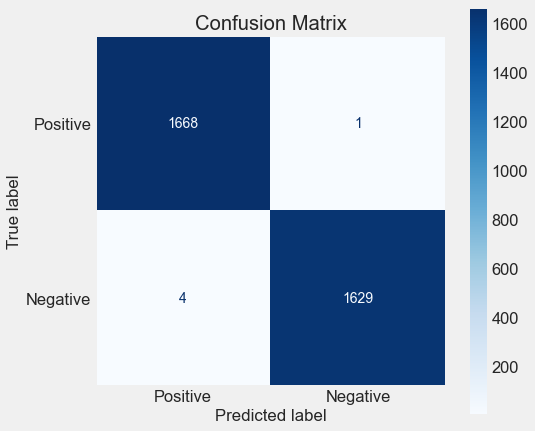

F1    Recall  Precision
0  0.998468  0.997551   0.999387

In [203]:
fn.confusion_report(rf_aug, X_lem_train, y_lem_train)

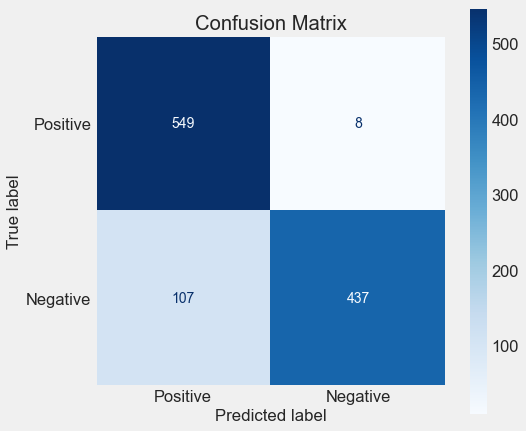

F1    Recall  Precision
0  0.883721  0.803309   0.982022

In [204]:
fn.confusion_report(rf_aug, X_lem_val, y_lem_val)

## Tuned Augmented Random Forest

In [205]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [206]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [207]:
# grid_clf = GridSearchCV(rf_aug, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [208]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [209]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
 ('clf',
  RandomForestClassifier(min_samples_split=10, n_jobs=-1, random_state=2021))]

In [210]:
tuned_rf_aug = Pipeline(steps=saved_steps)
tuned_rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [211]:
modeling.report(tuned_rf_aug, X_lem_train, y_lem_train, 'tuned_rf_aug', f'{steps}')

tuned_rf_aug has an average F1 of 0.8923784854925113


array([0.9       , 0.90127389, 0.88038278, 0.88924051, 0.89099526])

In [212]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
11      multibayes_aug       0.858952   
12       tuned_mnb_aug       0.873546   
15        tuned_rf_aug       0.892378   
13    tuned_simple_aug       0.896378   
14              rf_aug       0.896688   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
11                                     augmented_data  
12  [('tfidf', TfidfVectorizer()), ('clf', Multino...  
15  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
13  [('tfidf', TfidfVectorizer()), ('oversample', ...  
14                                     augmented data

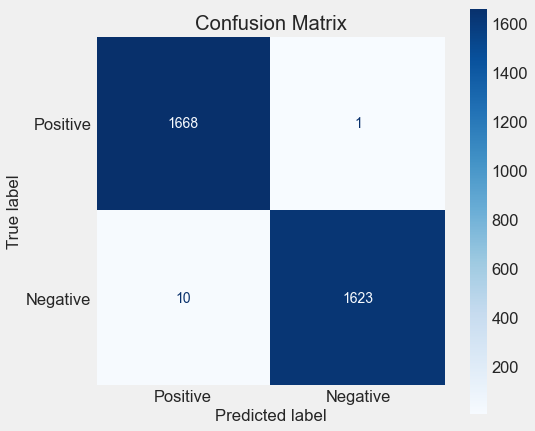

F1    Recall  Precision
0  0.996623  0.993876   0.999384

In [213]:
fn.confusion_report(tuned_rf_aug, X_lem_train, y_lem_train)

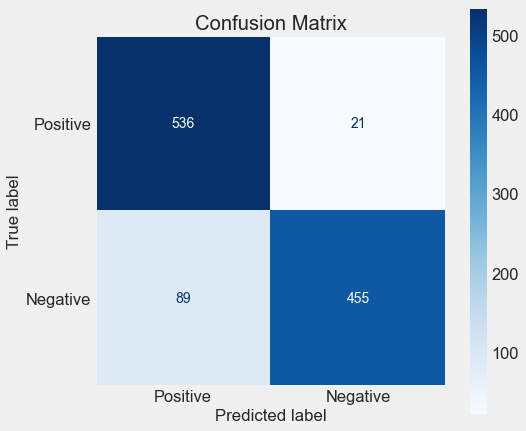

F1    Recall  Precision
0  0.892157  0.836397   0.955882

In [214]:
fn.confusion_report(tuned_rf_aug, X_lem_val, y_lem_val)

## RF on Stemmed Augmented Data

In [215]:
steps = [('tfidf', tfidf), ('clf', RF)]

In [216]:
stem_rf = Pipeline(steps=saved_steps)
stem_rf.fit(X_stem_train, y_stem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [217]:
modeling.report(stem_rf, X_stem_train, y_stem_train, 'rf_stem', f'{steps}')

rf_stem has an average F1 of 0.8934555779954911


array([0.89245586, 0.90996785, 0.88566828, 0.88712242, 0.89206349])

In [218]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
11      multibayes_aug       0.858952   
12       tuned_mnb_aug       0.873546   
13        tuned_rf_aug       0.892378   
16             rf_stem       0.893456   
14    tuned_simple_aug       0.896378   
15              rf_aug       0.896688   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
11                                     augmented_data  
12  [('tfidf', TfidfVectorizer()), ('clf', Multino...  
13  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
16  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
14  [('tfidf', TfidfVectorizer()), ('oversample', ...  
15                                     augmented data

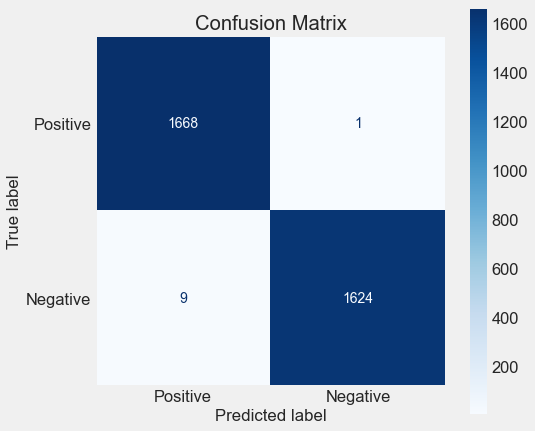

F1    Recall  Precision
0  0.996931  0.994489   0.999385

In [219]:
fn.confusion_report(stem_rf, X_stem_train, y_stem_train)

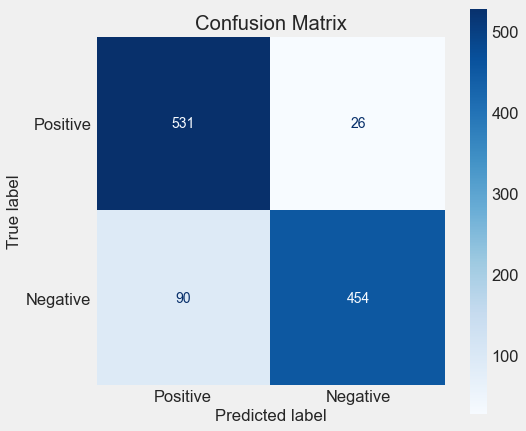

F1    Recall  Precision
0  0.886719  0.834559   0.945833

In [220]:
fn.confusion_report(stem_rf, X_stem_val, y_stem_val)

## Tuned RF on Augmented Stemmed Data

In [221]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [222]:
# grid_clf = GridSearchCV(stem_rf, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_stem_train, y_stem_train)

In [223]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [224]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
 ('clf',
  RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=2021))]

In [225]:
tuned_stem_rf = Pipeline(steps=saved_steps)
tuned_stem_rf.fit(X_stem_train, y_stem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_jobs=-1,
                                        random_state=2021))])

In [226]:
modeling.report(tuned_stem_rf, X_stem_train, y_stem_train, 'tuned_rf_stem',
                f'{steps}')

tuned_rf_stem has an average F1 of 0.8934711705793543


array([0.88745981, 0.90675241, 0.88102894, 0.90322581, 0.88888889])

In [227]:
modeling.history

Name  Accuracy (F1)  \
0            Dummy CLF       0.000000   
1         baseline_aug       0.000000   
2            LR simple       0.071395   
3                rf_mo       0.394579   
4         simple smote       0.450006   
5   tuned_simple_smote       0.461162   
6             tuned_rf       0.468909   
7      tuned_simple_mo       0.478765   
8            simple_mo       0.483339   
9     tuned_multibayes       0.484012   
10          multibayes       0.485421   
11      multibayes_aug       0.858952   
12       tuned_mnb_aug       0.873546   
13        tuned_rf_aug       0.892378   
14             rf_stem       0.893456   
17       tuned_rf_stem       0.893471   
15    tuned_simple_aug       0.896378   
16              rf_aug       0.896688   

                                                Notes  
0                        tfidf/no ngrams, no sampling  
1                                      augmented data  
2                        tfidf/no ngrams, no sampling  
3                               default random forest  
4                                               smote  
5   [('tfidf', TfidfVectorizer()), ('oversample', ...  
6   [('tfidf', TfidfVectorizer()), ('oversample', ...  
7   [('tfidf', TfidfVectorizer()), ('oversample', ...  
8                               minority oversampling  
9   [('tfidf', TfidfVectorizer()), ('oversample', ...  
10                                  minority oversamp  
11                                     augmented_data  
12  [('tfidf', TfidfVectorizer()), ('clf', Multino...  
13  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
14  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
17  [('tfidf', TfidfVectorizer()), ('clf', RandomF...  
15  [('tfidf', TfidfVectorizer()), ('oversample', ...  
16                                     augmented data

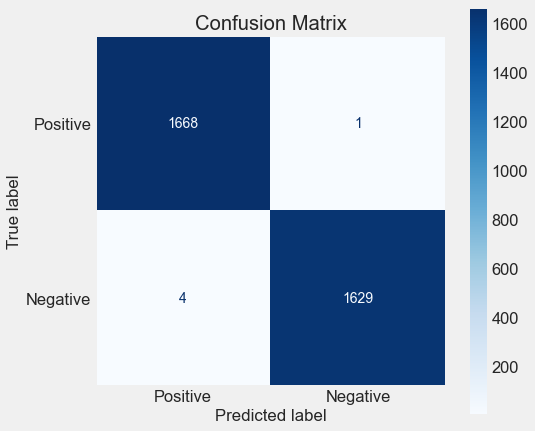

F1    Recall  Precision
0  0.998468  0.997551   0.999387

In [228]:
fn.confusion_report(tuned_stem_rf, X_stem_train, y_stem_train)

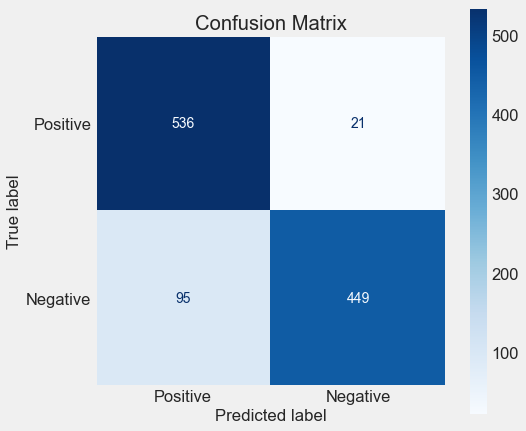

F1    Recall  Precision
0  0.885602  0.825368   0.955319

In [229]:
fn.confusion_report(tuned_stem_rf, X_stem_val, y_stem_val)

## XGBoost on Augmented

## XGBoost CLF

In [230]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, random_state=2021)

In [231]:
steps = [('tfidf', tfidf), ('clf', xgb_clf)]
x_boost = Pipeline(steps=steps)
x_boost.fit(X_lem_train, y_lem_train)

[18:12:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=2021,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [232]:
modeling.report(x_boost, X_lem_train, y_lem_train, 'x_boost', 'xgb_baseline')

[18:12:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

array([0.86312399, 0.88924559, 0.86119874, 0.88253968, 0.88424437])

## Validation Metrics

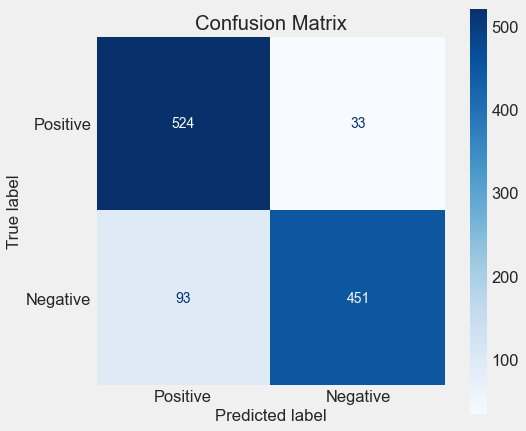

F1    Recall  Precision
0  0.877432  0.829044   0.931818

In [234]:
fn.confusion_report(x_boost, X_lem_val, y_lem_val)

## Metrics
F1=0.877432, Recall=0.829044, Precision=0.931818

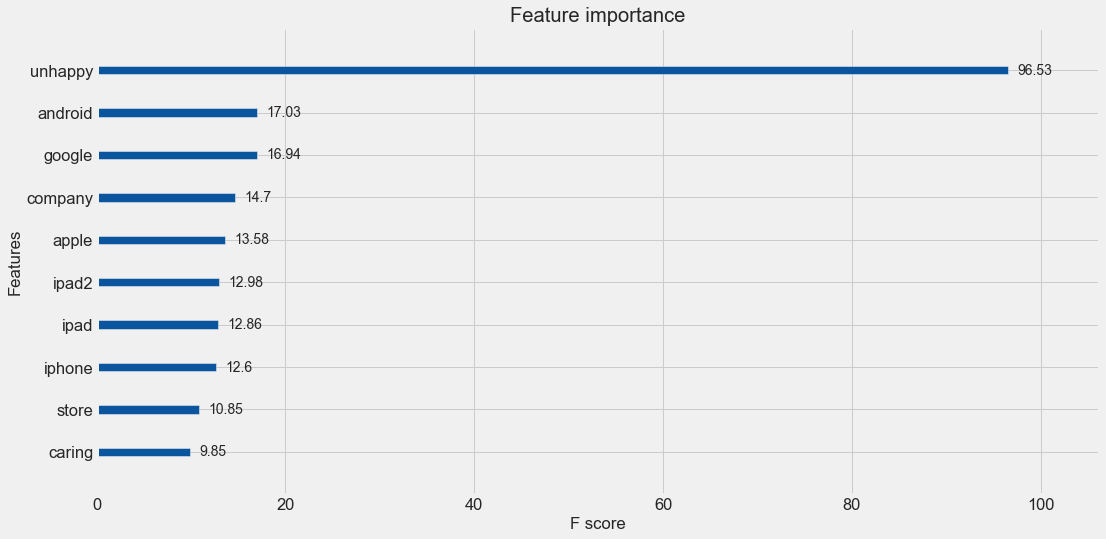

In [235]:
# setting feature names for the plot
x_boost[1].get_booster().feature_names = x_boost[0].get_feature_names()

# grabbing the booster
booster = x_boost[1].get_booster()

# grabbing importance dictionary
importance = booster.get_score(importance_type="gain")

# rounding values
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting
fig, ax=plt.subplots(figsize=(16,8))
plot_importance(importance, ax=ax, max_num_features=10, importance_type='gain', show_values=True)
plt.show()

In [236]:
fig, ax=plt.subplots(figsize=(500,250))
xgb.plot_tree(x_boost[1], ax=ax, num_trees=0)
plt.show()

## Tuning CLF

## Pipeline

In [237]:
xgb_tune = xgb.XGBClassifier(use_label_encoder=False,
                             random_state = 2021)

steps = [('tfidf', tfidf), ('clf', xgb_tune)]

xgb_hyp = Pipeline(steps=steps)

## RandomizedSearchCV

In [238]:
# # setting ngram list
# ngram_range = [(1, i) for i in range(1, 5)]

# params = { 'tfidf__ngram_range': ngram_range,
#            'tfidf__use_idf': (True, False),
#            'clf__max_depth': [3, 5, 6, 10, 15, 20],
#            'clf__learning_rate': rng.uniform(.01, .5, 5),
#            'clf__subsample': rng.uniform(0.5, 1.0, 5),
#            'clf__colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'clf__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'clf__n_estimators': range(50, 550, 100)}

# clf = RandomizedSearchCV(estimator=xgb_hyp,
#                          param_distributions=params,
#                          scoring='f1',
#                          n_iter=25,
#                          n_jobs=-1,
#                          verbose=2)

# clf.fit(X_lem_train, y_lem_train)

# print("Best parameters:", clf.best_params_)
# print("Best F1: ", clf.best_score_)

In [239]:
# setting best estimator
# tuned_xgb = clf.best_estimator_

## Saving Results
Saving results so we can run the notebook without doing the RandomizedSearchCV again.

In [240]:
# params_list = clf.cv_results_["params"]
# scores = clf.cv_results_["mean_test_score"]

In [241]:
# saving params 
params = [{'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.4850212554551075,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 50,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 450,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.7999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 150,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 350,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.5,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 15,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 250,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 450,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.6},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 350,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 150,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 250,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 450,
  'clf__max_depth': 20,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.8999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 250,
  'clf__max_depth': 20,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.4850212554551075,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.5,
  'clf__colsample_bylevel': 0.7999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 50,
  'clf__max_depth': 15,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4}]

In [242]:
# saving scores
scores = np.array([0.8480393 , 0.87381837, 0.86554458, 0.8742417 , 0.87217505,
       0.87557885, 0.86351348, 0.88191702, 0.87153065, 0.87333046,
       0.87322496, 0.87646287, 0.87911376, 0.87950243, 0.86590612,
       0.87817528, 0.87611077, 0.88261812, 0.86741645, 0.88204542,
       0.87114124, 0.86970715, 0.87020325, 0.86485986, 0.86981951])

In [243]:
# results_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
#                         pd.DataFrame(clf.cv_results_["mean_test_score"],
#                                      columns=["F1 Accuracy"])],axis=1)

In [244]:
results_df = pd.concat([pd.DataFrame(params),
                        pd.DataFrame(scores,
                                     columns=["F1 Accuracy"])],axis=1)

In [245]:
results_df.sort_values(by=['F1 Accuracy'], ascending=False)

tfidf__use_idf tfidf__ngram_range  clf__subsample  clf__n_estimators  \
17           False             (1, 2)        0.992601                150   
19           False             (1, 2)        0.984970                450   
7             True             (1, 1)        0.897893                350   
13           False             (1, 2)        0.992601                450   
12           False             (1, 3)        0.897893                250   
15           False             (1, 3)        0.897893                450   
11            True             (1, 2)        0.891593                450   
16           False             (1, 3)        0.992601                350   
5             True             (1, 2)        0.897893                150   
3            False             (1, 4)        0.984970                350   
1             True             (1, 2)        0.992601                350   
9            False             (1, 1)        0.992601                450   
10           False             (1, 4)        0.992601                150   
4            False             (1, 3)        0.891593                450   
8             True             (1, 4)        0.992601                250   
20            True             (1, 4)        0.891593                250   
22            True             (1, 4)        0.891593                150   
24            True             (1, 2)        0.992601                 50   
21           False             (1, 4)        0.992601                250   
18            True             (1, 3)        0.891593                250   
14            True             (1, 4)        0.897893                150   
2            False             (1, 4)        0.897893                 50   
23            True             (1, 3)        0.992601                250   
6             True             (1, 1)        0.984970                350   
0             True             (1, 4)        0.984970                350   

    clf__max_depth  clf__learning_rate  clf__colsample_bytree  \
17              10            0.431695                    0.4   
19              20            0.159538                    0.6   
7               10            0.028170                    0.5   
13               3            0.315785                    0.7   
12               6            0.159538                    0.4   
15              10            0.028170                    0.4   
11              10            0.159538                    0.6   
16               6            0.159538                    0.7   
5               10            0.431695                    0.4   
3               10            0.159538                    0.9   
1                3            0.485021                    0.8   
9               10            0.431695                    0.7   
10               5            0.315785                    0.8   
4                6            0.028170                    0.6   
8               15            0.315785                    0.4   
20              20            0.159538                    0.6   
22               5            0.485021                    0.9   
24              15            0.028170                    0.6   
21              10            0.315785                    0.8   
18              10            0.315785                    0.9   
14               5            0.315785                    0.6   
2                5            0.431695                    0.6   
23               6            0.431695                    0.5   
6                3            0.028170                    0.6   
0                3            0.028170                    0.4   

    clf__colsample_bylevel  F1 Accuracy  
17                     0.5     0.882618  
19                     0.9     0.882045  
7                      0.5     0.881917  
13                     0.7     0.879502  
12                     0.4     0.879114  
15                     0.5     0.878175  
11                     0.4     0.876463  


## Best XGB Model

In [246]:
# clf.best_estimator_.get_params()['steps']

In [247]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
               ('clf', XGBClassifier(base_score=0.5, booster='gbtree', 
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=0.4,gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.4316946669556227,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, 
                                     monotone_constraints='()',
                                     n_estimators=150, n_jobs=8,
                                     num_parallel_tree=1, random_state=2021,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1,
                                     subsample=0.9926009399652742,
                                     tree_method='exact',
                                     use_label_encoder=False,
                                     validate_parameters=1, verbosity=None))]

In [248]:
tuned_x = Pipeline(steps=saved_steps)
tuned_x.fit(X_lem_train, y_lem_train)

[18:16:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=0.4, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.4316946669556227,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=8, num_parallel_tree=1, random_state=2021,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.9926009399652742,
                               tree_method='exact', use_label_encoder=False,
      

## Validation Metrics

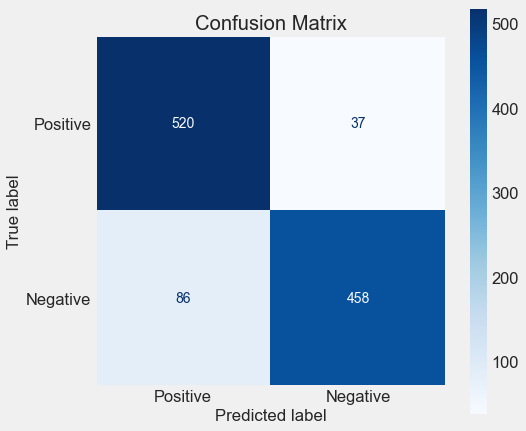

F1    Recall  Precision
0  0.881617  0.841912   0.925253

In [249]:
fn.confusion_report(tuned_x, X_lem_val, y_lem_val)

<font size="4">F1=0.881617, Recall=0.841912, Precision=0.925253</font>

## Features

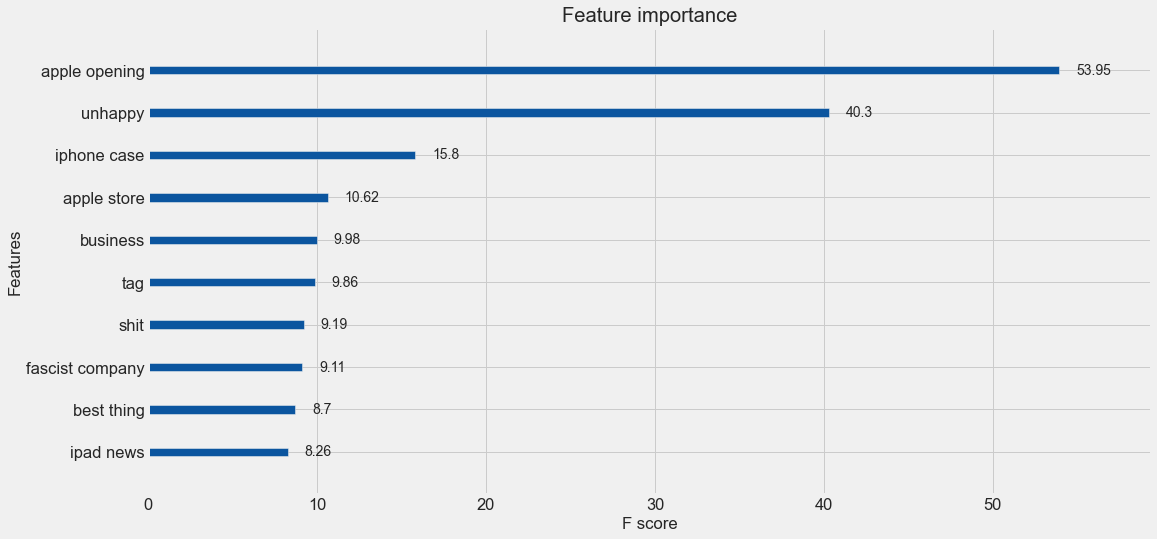

In [250]:
# setting feature names for the plot
tuned_x[1].get_booster().feature_names = tuned_x[0].get_feature_names()

# grabbing the booster
booster = tuned_x[1].get_booster()

# grabbing importance dictionary
importance = booster.get_score(importance_type="gain")

# rounding values
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting
fig, ax=plt.subplots(figsize=(16,8))
plot_importance(importance, ax=ax, max_num_features=10, importance_type='gain', show_values=True)
plt.show()

## Tree Plot

In [251]:
fig, ax=plt.subplots(figsize=(500,250))
xgb.plot_tree(tuned_x[1], ax=ax, num_trees=0)
plt.show()

# Final Models

## Alternate Model: 
<font size="4">Random Forest CLF Tuned on Augmented Lemmatized Data</font>
    
<font size="4">Metrics: F1=0.892157, Recall=0.836397, Precision=0.955882</font>

In [252]:
tuned_rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

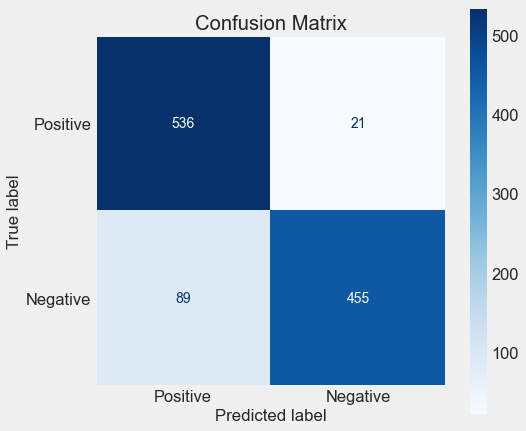

F1    Recall  Precision
0  0.892157  0.836397   0.955882

In [253]:
fn.confusion_report(tuned_rf_aug, X_lem_val, y_lem_val)

## Alternate Model Feature Importances

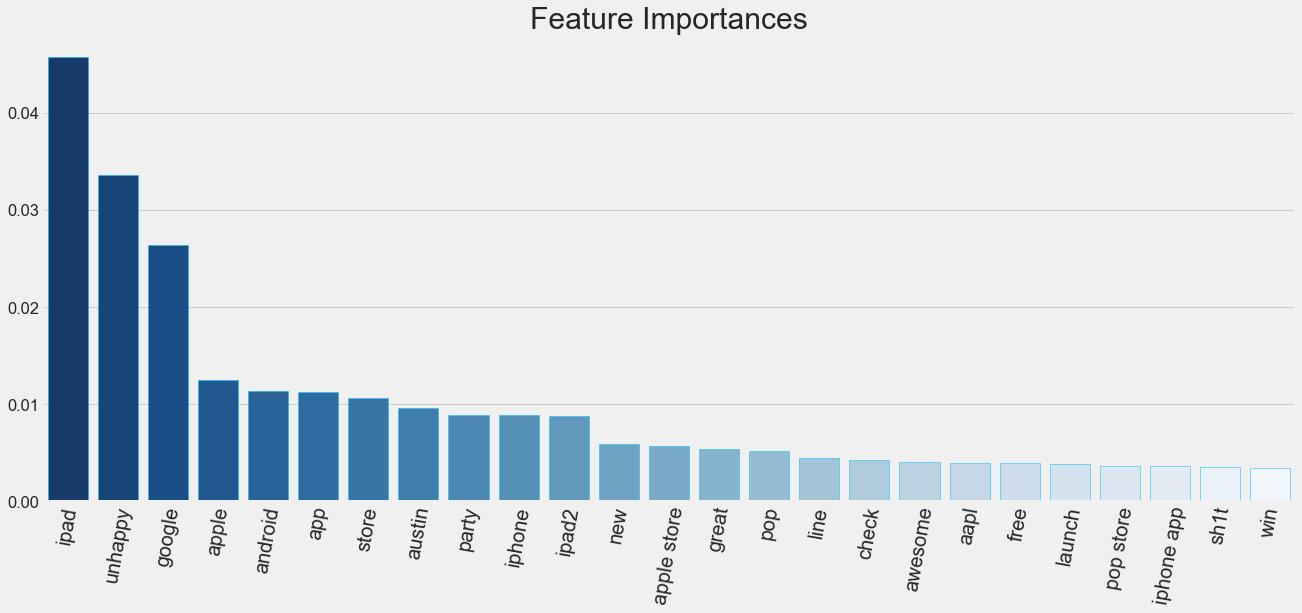

In [254]:
vz.feature_plot(tuned_rf_aug)

## Validating Alternate Model on Holdout Data

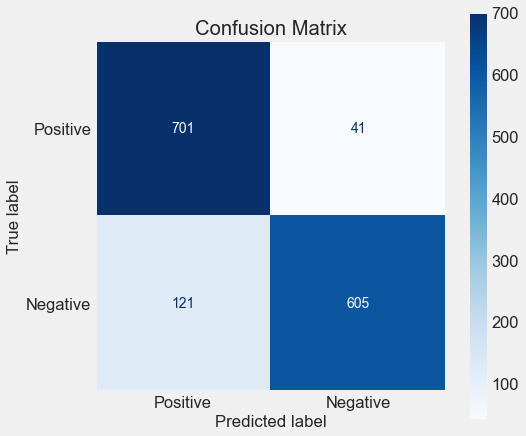

F1    Recall  Precision
0  0.881924  0.833333   0.936533

In [255]:
fn.confusion_report(tuned_rf_aug, X_lem_testing, y_lem_testing)

## Alternate Model Validation Metrics:

<font size="4">F1=0.881924, Recall=0.833333, Precision=0.936533</Font>

## Fitting Alternate Model on All Lemmatized Augmented Data

In [256]:
tuned_rf_aug.fit(X_lem_aug, y_lem_aug)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

## Pickling Alternate Model

In [257]:
# path = os.path.join(gparent, 'models', 'RF_model.pkl')
# file = open(path, 'wb')
# pickle.dump(tuned_rf_aug, file)
# file.close()

## Final Model:
<font size="4">Logistic Regression CLF Tuned on Augmented Lemmatized Data</font>

<font size="4">Metrics: F1=0.88755, Recall=0.8125, Precision=0.977876</font>

In [259]:
tuned_simple.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

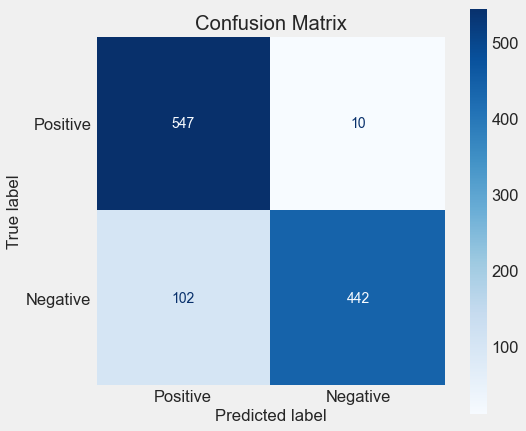

F1  Recall  Precision
0  0.88755  0.8125   0.977876

In [260]:
fn.confusion_report(tuned_simple, X_lem_val, y_lem_val)

## Validating Final Model on Holdout Data

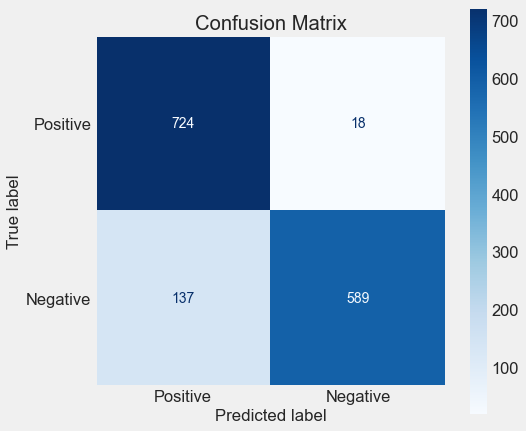

F1    Recall  Precision
0  0.883721  0.811295   0.970346

In [261]:
fn.confusion_report(tuned_simple, X_lem_testing, y_lem_testing)

## Final Model Validation Metrics: 
<font size="4">F1=0.883721, Recall=0.811295, Precision=0.970346</font>

## Coefficients & Odds

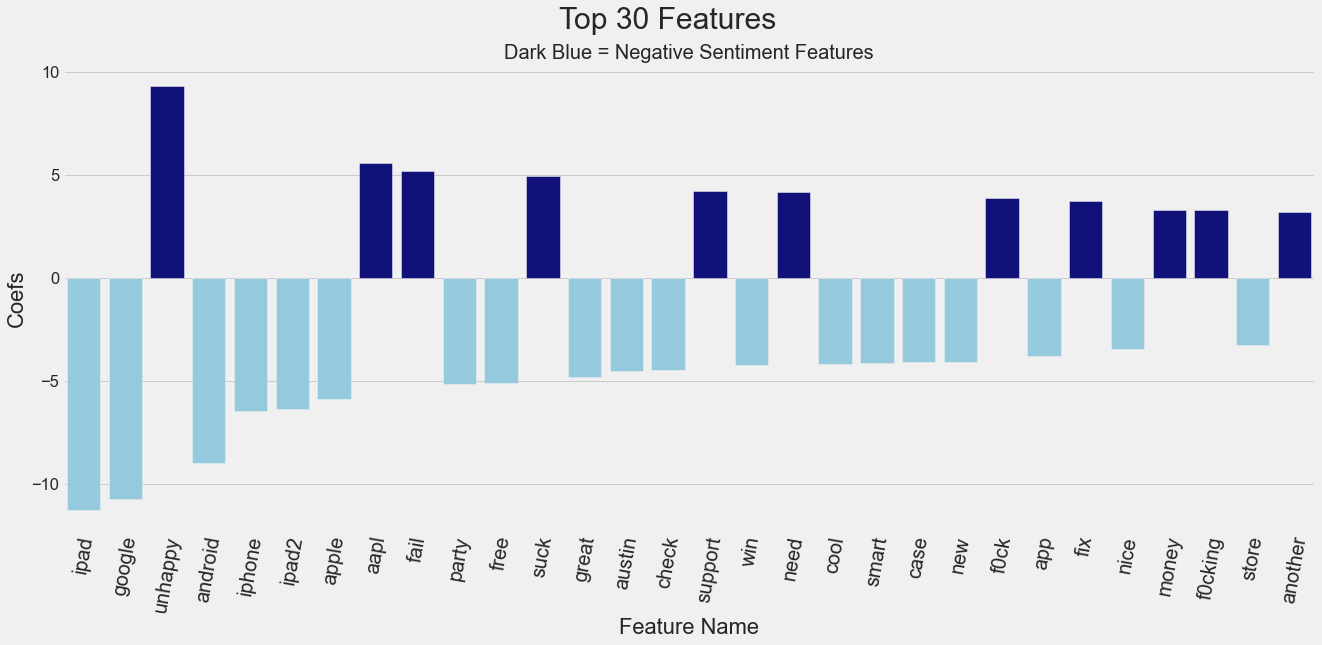

In [262]:
vz.base_coefs(tuned_simple)

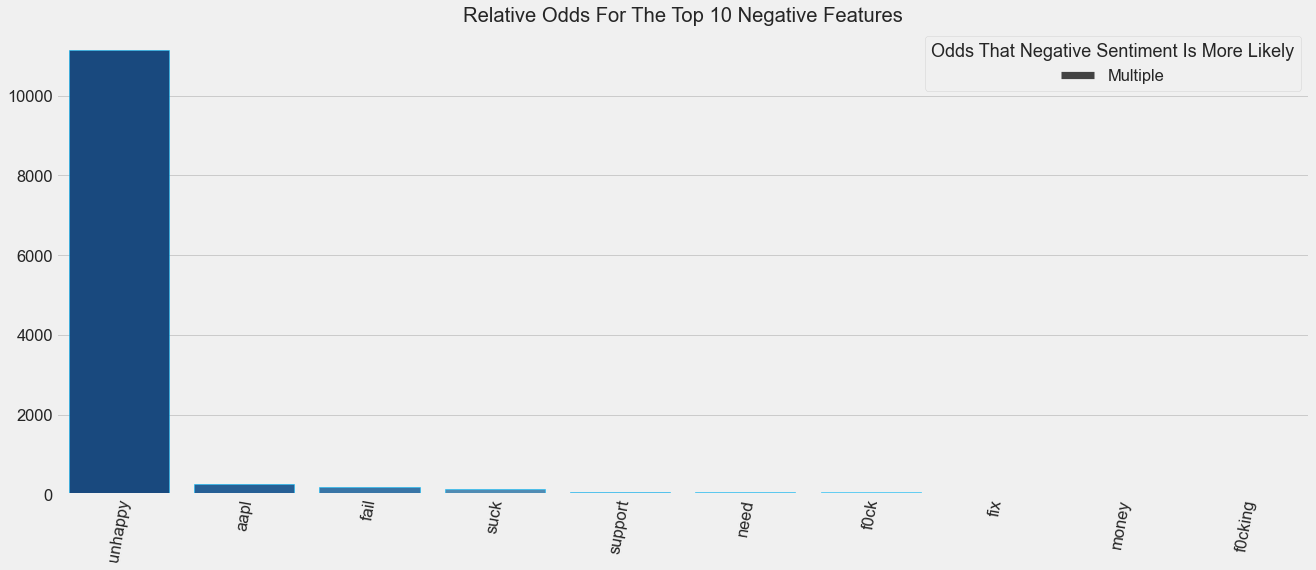

In [263]:
vz.base_neg_odds(tuned_simple)

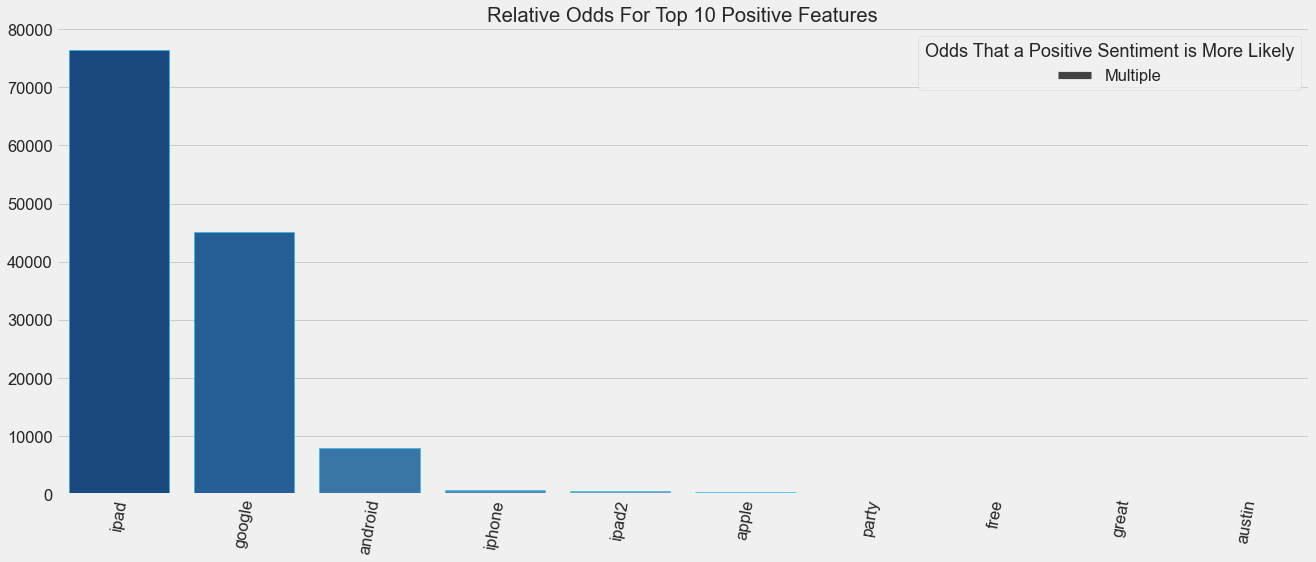

In [264]:
vz.base_pos_odds(tuned_simple)

## Fitting Alternate Model on All Lemmatized Augmented Data

In [265]:
tuned_simple.fit(X_lem_aug, y_lem_aug)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

## Pickling Alternate Model

In [266]:
# path = os.path.join(gparent, 'models', 'LR_model.pkl')
# file = open(path, 'wb')
# pickle.dump(tuned_simple, file)
# file.close()